# MVP - Engenharia de Dados
## Análise de índices de mortalidade no Brasil

# 1️⃣ Objetivo
_____

Este MVP tem como objetivo construir um pipeline de dados na nuvem para analisar dados de mortalidade no Brasil, utilizando tecnologias em nuvem com Databricks e seu Delta Lake. O pipeline envolverá as etapas de busca, coleta, modelagem, carga e análise dos dados, com o propósito de fornecer insights sobre padrões de mortalidade no país.

O problema central que este MVP busca resolver é a falta de uma visão consolidada e acessível dos dados de mortalidade, que permita identificar tendências, anomalias e fatores relevantes para a saúde pública. Para isso, serão respondidas as seguintes perguntas:

1)  Qual o número total de óbitos registrados no Brasil ao longo do tempo?

2)  Quais são as principais causas de morte no Brasil? 

3)  Qual a distribuição da mortalidade por faixa etária? 

4)  Quais são as causas de morte mais comuns entre crianças, adultos e idosos?

5)  O sexo das vítimas influencia as causas da morte?

6)  Houve mudanças nas principal causa de morte ao longo do tempo? 

7)  Qual é a proporção de óbitos que ocorreram em hospitais versus outros locais? 

8)  Qual é a distribuição de óbitos por raça/cor? 

9)  O estado civil tem relação com a mortalidade? 

10) Quais locais apresentam as maiores taxas de mortalidade? 

11) Em quais horários ocorrem mais mortes? 

12) A taxa de homicídios aumentou ou diminuiu ao longo dos anos? 

13) Quais regiões apresentam maior incidência de suicídios?

14) Qual é a distribuição de óbitos por causas relacionadas ao trabalho?



Ao final do projeto, espera-se entregar uma base de dados confiável com análises que contribuam para a compreensão dos fatores que impactam a mortalidade no Brasil.

# 2️⃣ Fonte dos Dados e Coleta
___

Os dados utilizados neste projeto foram obtidos de fontes oficiais e públicas, portanto há problemas com a confidencialidade destes dados. A base principal é o Sistema de Informações sobre Mortalidade (SIM), que contém registros detalhados sobre óbitos ocorridos no Brasil. Foram coletados os dados entre os anos de 2006 e 2024.

2.1 Tabela Fato – Mortalidade Geral 

A tabela fato do projeto, denominada `mortalidade_geral_gold`, foi construída a partir dos arquivos de mortalidade geral disponibilizados anualmente no portal de dados abertos do SUS:

🔗 Fonte: Sistema de Informações sobre Mortalidade (SIM) – OpenDataSUS (https://opendatasus.saude.gov.br/dataset/sim)

Os arquivos foram baixados manualmente, ano a ano, no formato CSV, e posteriormente feito o upload no DBFS do Databricks. Vale ressaltar que o ano de 2024 é uma prévia, ou seja, não está completo até a data de hoje (11/04/2025), segundo a fonte.

2.2 Tabelas Dimensão

As tabelas dimensão foram obtidas de diferentes fontes, conforme descrito abaixo:

- CID-10: Classificação Internacional de Doenças – 10ª Revisão (`CID_10_gold`)

  Para obter a descrição das causas de morte, foi utilizada a tabela de subcategorias da CID-10, versão 2008, extraída de um arquivo ZIP disponível no portal do Datasus:

  🔗 Fonte: CID-10 – Subcategorias (http://www2.datasus.gov.br/cid10/V2008/descrcsv.htm)

  O arquivo extraído foi o CID-10-SUBCATEGORIAS.CSV, que contém as descrições das subcategorias e categorias da CID-10. Esse conjunto de dados foi escolhido porque apresenta os códigos padronizados utilizados para registrar as causas de óbitos no Brasil.

- Divisão Territorial Brasileira (`municipios_gold`)

  Para relacionar os óbitos às respectivas localidades, foi utilizada a tabela da Divisão Territorial Brasileira 2023, disponibilizada pelo IBGE:

  🔗 Fonte: Divisão Territorial Brasileira – IBGE (https://www.ibge.gov.br/geociencias/organizacao-do-territorio/divisao-regional/23701-divisao-territorial-brasileira.html)

  O arquivo extraído do ZIP foi RELATORIO_DTB_BRASIL_MUNICIPIO.csv, que contém informações sobre regiões geográficas intermediárias e imediatas, municípios, distritos e seus respectivos códigos.

- Demais tabelas dimensão

  As demais tabelas dimensão foram criadas manualmente, pois possuem poucas colunas (apenas 2) e linhas (a maior delas possui apenas 7), tornando viável sua construção sem a necessidade de fontes externas. Foram criadas no formato CSV, separadas por ";", utilizando um editor de texto. Essas tabelas foram baseadas diretamente nas informações contidas na tabela fato `mortalidade_geral_gold` e incluem:

  - Circunstância (`circunstancia_gold`)

  - Raça/Cor (`cor_gold`)

  - Estado Civil (`estado_civil_gold`)

  - Local do Óbito (`local_obito_gold`)

  - Sexo (`sexo_gold`)

  Essas tabelas foram projetadas para servir de referência às respectivas colunas na base de mortalidade geral, garantindo a integridade dos dados no processo analítico.

# 3️⃣ Modelagem e Catálogo de Dados
___

Para estruturar e organizar os dados de forma eficiente, foi adotado o Esquema Estrela, um dos modelos mais utilizados em Data Warehousing e Business Intelligence.


## 3.1 Estrutura do Esquema Estrela

O esquema estrela do projeto foi construído com uma tabela fato principal contendo os registros de mortalidade e 7 tabelas dimensão para compor as análises. A estrutura ficou organizada da seguinte forma:

 📊 Tabela Fato: `mortalidade_geral_gold`
  
  - Esta tabela contém os registros de óbitos e é o núcleo central do esquema. Cada linha representa um óbito registrado, com detalhes como data, local, causa da morte e características da pessoa falecida.

  📊 Tabelas Dimensão: `municipios_gold`, `cid_10_gold`, `circunstancia_gold`, `local_obito_gold`, `estado_civil_gold`, `sexo_gold` e `cor_gold`.

  - Foram criadas tabelas auxiliares para armazenar descrições de variáveis categóricas e facilitar a análise por meio de junções (joins) entre as tabelas.

## 3.2 Catálogo de Dados

### Tabela `mortalidade_geral_gold`

A tabela fato foi criada a partir da base original do SIM, que continha 132 colunas. Durante o processo de ETL, foram removidos campos irrelevantes, resultando em uma estrutura mais enxuta e otimizada para análise. São eles:

| Campo        | Descrição | Datatype | Tamanho | Valores possíveis | Chave estrangeira |
|--------------|-----------|----------|---------|-------------------|-------------------|
| `ACIDTRAB` | Indica se o evento que desencadeou o óbito está relacionado ao processo de trabalho. | string | 8 | Sim; Não; Ignorado | - |
| `ASSISTMED` | Se refere ao atendimento médico continuado que o paciente recebeu, ou não, durante a enfermidade que ocasionou o óbito. | string | 8 | Sim; Não; Ignorado | - |
| `CAUSABAS` | Código da causa da morte na declaração de óbito. | string | 3 a 4 | Códigos CID-10, ex: 'A012', 'T71', 'U049' | `cid_10_gold.SUBCAT` |
| `CIRCOBITO` | Código do tipo de morte violenta ou circunstâncias em que se deu a morte não natural. | string | 1 | 1; 2; 3; 4; 9 | `circunstancia_gold.COD_CIRC` |
| `CODMUNOCOR` | Código relativo ao município onde ocorreu o óbito. | string | 6 | Códigos numéricos, ex: '110010', '110037', '110020' | `municipios_gold.CODMUN` |
| `DTOBITO` | Data em que ocorreu o óbito. | date | 10 | Datas no formato 'yyyy-mm-dd', ex: '2023-07-15' | - |
| `ESTCIV` | Código da situação conjugal do falecido informada pelos familiares. | string | 1 | 1; 2; 3; 4; 5; 9 | `estado_civil_gold.COD_ESTCIVIL` |
| `HORAOBITO` | Horário do óbito. | string | 5 | Horário no formato de 00(:00) a 23(:59), ex: '08:45' | - |
| `IDADE_GRUPO` |Indica a unidade da idade do falecido em minutos, horas, dias, meses ou anos:<br> se 0 = minuto;<br> se 1 = hora,<br> se 2 = dia;<br> se 3= mês;<br> se 4 = ano;<br> se 5 = idade maior que 100 anos;<br> se 9 = ignorado. | string | 1 | 0; 1; 2; 3; 4; 5; 9 | - |
| `IDADE_QTD` | Indica a quantidade de unidades da idade do falecido:<br> Idade menor de 1 hora: campo varia de  01 a 59  (minutos);<br> De 1 a 23 horas: campo varia de 01 a 23 (horas);<br> De 24 horas a 29 dias: campo varia de 01 a 29 (dias);<br> De 1 mês a menos de 12 meses completos: campo varia de 01 a 11 (meses);<br> Anos: campo varia de 00 a 99;<br> Maior que 100: campo varia de 00 a 50;<br> Ignorado: 99. | string | 2 | 00 a 99, conforme a unidade | - |
| `LOCOCOR` | Código do local de ocorrência do óbito. | string | 1 | 1; 2; 3; 4; 5; 6; 9 | `local_obito_gold.COD_LOCAL` |
| `RACACOR` | Código da cor informada pelo responsável pelas informações do falecido. | string | 1 | 1; 2; 3; 4; 5; 9 | `cor_gold.COD_COR` |
| `SEXO` | Código do sexo do falecido. | string | 1 | 1; 2; 9 | `sexo_gold.COD_SEXO` |

### Tabela `cid_10_gold`

Relaciona os códigos da CID-10 com a descrição das doenças e causas de mortalidade. Sua colunas são:

| PK  | Nome da Coluna | Descrição | Datatype | Tamanho | Valores Possíveis | Relacionamento |
|-----|---------------|-----------|---------|---------|------------------|---------------|
| ✅  | `SUBCAT` | Código da causa da morte na declaração de óbito. | string | 3 a 4 | Códigos CID-10, onde o primeiro caractere é uma letra e o restante um número, por exemplo: 'A012', 'T71' e 'U049'. | `mortalidade_geral.CAUSABAS = cid_10.SUBCAT` |
|     | `DESCRICAO` | Descrição da causa da morte na declaração de óbito. | string | 5 a 114 | Exemplos: 'Cólera devida a Vibrio cholerae 01, biótipo cholerae', 'Febre paratifóide A', 'Botulismo'. | - |


### Tabela `circunstancia_gold`

Relaciona o código do tipo de morte com sua descrição. Suas colunas são:

| PK  | Nome da Coluna | Descrição | Datatype | Tamanho | Valores Possíveis | Relacionamento |
|-----|---------------|-----------|---------|---------|------------------|---------------|
| ✅  | `COD_CIRC` | Código do tipo de morte violenta ou circunstâncias em que se deu a morte não natural. | string | 1 | 1; 2; 3; 4; 9 | `mortalidade_geral.CIRCOBITO = circunstancia.COD_CIRC` |
|     | `DESCR_CIRC` | Descrição do tipo de morte. | string | 6 a 9 | acidente, suicídio, homicídio, outras circunstâncias, ignorado | - |


### Tabela `municipios_gold`

Contém os códigos e nomes dos municípios e estados do Brasil. Suas colunas são:

| PK  | Nome da Coluna | Descrição | Datatype | Tamanho | Valores Possíveis | Relacionamento |
|-----|---------------|-----------|---------|---------|------------------|---------------|
| ✅  | `CODMUN` | Código relativo ao município onde ocorreu o óbito. | string | 6 | códigos numéricos, ex: '110010', '110037', '110020' | `mortalidade_geral.CODMUNOCOR = municipios.CODMUN` |
|     | `MUNICIPIO` | Nome do município onde ocorreu o óbito. | string | 3 a 32 | ex: Guajará-Mirim, Alto Alegre dos Parecis, Rio de Janeiro | - |
|     | `UF` | Código do estado onde ocorreu o óbito. | string | 2 | ex: RJ, SP, MG | - |


### Tabela `estado_civil_gold`

Armazena o código e sua descrição de estado civil. Suas colunas são:

| PK  | Nome da Coluna      | Descrição                                                    | Datatype | Tamanho  | Valores Possíveis                                            | Relacionamento |
|-----|---------------------|--------------------------------------------------------------|----------|----------|-------------------------------------------------------------|---------------|
| ✅  | `COD_ESTCIVIL`      | Código da situação conjugal do falecido informada pelos familiares. | string   | 1        | 1; 2; 3; 4; 5; 9                                            | `mortalidade_geral.ESTCIV = estado_civil.COD_ESTCIVIL` |
|     | `DESCR_ESTADO`      | Descrição da situação conjugal do falecido informada pelos familiares. | string   | 5 a 33   | Solteiro; Casado; Viúvo; Separado judicialmente/divorciado; União estável; Ignorado. | - |


### Tabela `sexo_gold`

Relaciona o sexo do falecido com seu código. Suas colunas são:

| PK  | Nome da Coluna  | Descrição                        | Datatype | Tamanho  | Valores Possíveis               | Relacionamento |
|-----|---------------|--------------------------------|----------|----------|--------------------------------|---------------|
| ✅  | `COD_SEXO`    | Código do sexo do falecido.   | string   | 1        | 1; 2; 9                        | `mortalidade_geral.SEXO = sexo.COD_SEXO` |
|     | `DESCR_SEXO`  | Sexo do falecido.             | string   | 8 a 9    | Masculino; Feminino; Ignorado  | - |


### Tabela `cor_gold`

Relaciona a raça/cor do falecido com seu código. Suas colunas são:

| PK  | Nome da Coluna  | Descrição                                                  | Datatype | Tamanho  | Valores Possíveis                 | Relacionamento |
|-----|---------------|------------------------------------------------|----------|----------|--------------------------------|---------------|
| ✅  | `COD_COR`    | Código da cor informada pelo responsável pelas informações do falecido. | string   | 1        | 1; 2; 3; 4; 5; 9                 | `mortalidade_geral.RACACOR = cor.COD_COR` |
|     | `DESCR_COR`  | Cor/raça do falecido.                           | string   | 5 a 9    | Branca; Preta; Amarela; Parda; Indígena | - |


### Tabela `local_obito_gold`

Relaciona o código do local de óbito com sua descrição. Suas colunas são:

| PK  | Nome da Coluna  | Descrição                                  | Datatype | Tamanho  | Valores Possíveis                                         | Relacionamento |
|-----|---------------|--------------------------------|----------|----------|------------------------------------------------|---------------|
| ✅  | `COD_LOCAL`  | Código do local de ocorrência do óbito. | string   | 1        | 1; 2; 3; 4; 5; 6; 9                               | `mortalidade_geral.LOCOCOR = local_obito.COD_LOCAL` |
|     | `DESCR_LOCAL` | Descrição do local de óbito.         | string   | 6 a 32   | Hospital; Outros estabelecimentos de saúde; Domicílio; Via pública; Outros; Aldeia indígena; Ignorado | - |


## 3.3 Diagrama Entidade Relacionamento

![Diagrama ER](https://raw.githubusercontent.com/marcospaulofg/Data-Science/main/Engenharia%20de%20Dados/Diagrama%20ER.jpg)

# 4️⃣ Carga
___

Nesta etapa será feita a carga dos dados para o Delta Lake do Databricks. Será feito um pipeline de ETL (Extração, Transformação e Carga) e todos os processos realizados serão documentados.

Inicialmente, importaremos as bibliotecas necessárias e criaremos o banco de dados, organizando os dados em três camadas dentro da arquitetura medallion (Bronze, Silver e Gold). Cada camada terá um papel na preparação dos dados:

🥉 Camada Bronze: Armazena os dados brutos, exatamente como foram extraídos das fontes originais, sem qualquer modificação.

🥈 Camada Silver: Aplica limpeza, padronização e enriquecimento dos dados, removendo inconsistências e garantindo a qualidade.

🥇 Camada Gold: Otimiza as tabelas para consultas analíticas e geração de insights para consumo final.

## 💾 Banco de dados
___

In [0]:
from pyspark.sql.functions import col, when, concat, substring, lit, to_date  # Para manipular dados em spark
from pyspark.sql import Row  # Para manipular dados em spark
import matplotlib.pyplot as plt  # Para plotar gráficos
import seaborn as sns  # Para plotar gráficos
import pandas as pd  # Para criar dataframes que possam ser lidos pelo matplotlib e seaborn
import warnings  # Para desativar warnings
warnings.filterwarnings("ignore")

Vamos criar 3 bancos de dados para separar nosso projeto: `bronze`, `silver` e `gold`. Iniciaremos guardando os dados crus no banco de dados `bronze`.

In [0]:
%sql
CREATE DATABASE IF NOT EXISTS bronze;

CREATE DATABASE IF NOT EXISTS bilver;

CREATE DATABASE IF NOT EXISTS bold

## 🥉 Camada Bronze
___

In [0]:
%sql
USE bronze

Os dados foram subidos diretamente no DBFS através do menu `Catalog` do Databricks, portanto vamos apenas armazená-los no banco de dados `bronze` na sua forma crua.

Vamos iniciar com as `tabelas dimensões`, e em seguida o que será nossa `tabela fato`, que está separada por data em vários CSV diferentes.

In [0]:
%sql
CREATE TABLE cid_10_bronze
USING csv
OPTIONS (
  path 'dbfs:/FileStore/tables/CID_10_SUBCATEGORIAS.csv',
  header 'true',
  delimiter ';',
  encoding 'ISO-8859-1',
  inferSchema 'true'
);

CREATE TABLE circunstancia_bronze
USING csv
OPTIONS (
  path 'dbfs:/FileStore/tables/circunstancia.csv',
  header 'true',
  delimiter ';',
  encoding 'ISO-8859-1',
  inferSchema 'true'
);

CREATE TABLE cor_bronze
USING csv
OPTIONS (
  path 'dbfs:/FileStore/tables/cor.csv',
  header 'true',
  delimiter ';',
  encoding 'ISO-8859-1',
  inferSchema 'true'
);

CREATE TABLE estado_civil_bronze
USING csv
OPTIONS (
  path 'dbfs:/FileStore/tables/estado_civil.csv',
  header 'true',
  delimiter ';',
  encoding 'ISO-8859-1',
  inferSchema 'true'
);

CREATE TABLE local_obito_bronze
USING csv
OPTIONS (
  path 'dbfs:/FileStore/tables/local_obito.csv',
  header 'true',
  delimiter ';',
  encoding 'ISO-8859-1',
  inferSchema 'true'
);

CREATE TABLE municipios_bronze
USING csv
OPTIONS (
  path 'dbfs:/FileStore/tables/municipios.csv',
  header 'true',
  delimiter ';',
  encoding 'ISO-8859-1',
  inferSchema 'true'
);

CREATE TABLE sexo_bronze
USING csv
OPTIONS (
  path 'dbfs:/FileStore/tables/sexo.csv',
  header 'true',
  delimiter ';',
  encoding 'ISO-8859-1',
  inferSchema 'true'
);

CREATE TABLE mortalidade_geral_2006
USING csv
OPTIONS (
  path 'dbfs:/FileStore/MortalidadeGeral/Mortalidade_Geral_2006.csv',
  header 'true',
  delimiter ';',
  encoding 'ISO-8859-1',
  inferSchema 'true'
);

CREATE TABLE mortalidade_geral_2007
USING csv
OPTIONS (
  path 'dbfs:/FileStore/MortalidadeGeral/Mortalidade_Geral_2007.csv',
  header 'true',
  delimiter ';',
  encoding 'ISO-8859-1',
  inferSchema 'true'
);

CREATE TABLE mortalidade_geral_2008
USING csv
OPTIONS (
  path 'dbfs:/FileStore/MortalidadeGeral/Mortalidade_Geral_2008.csv',
  header 'true',
  delimiter ';',
  encoding 'ISO-8859-1',
  inferSchema 'true'
);

CREATE TABLE mortalidade_geral_2009
USING csv
OPTIONS (
  path 'dbfs:/FileStore/MortalidadeGeral/Mortalidade_Geral_2009.csv',
  header 'true',
  delimiter ';',
  encoding 'ISO-8859-1',
  inferSchema 'true'
);

CREATE TABLE mortalidade_geral_2010
USING csv
OPTIONS (
  path 'dbfs:/FileStore/MortalidadeGeral/Mortalidade_Geral_2010.csv',
  header 'true',
  delimiter ';',
  encoding 'ISO-8859-1',
  inferSchema 'true'
);

CREATE TABLE mortalidade_geral_2011
USING csv
OPTIONS (
  path 'dbfs:/FileStore/MortalidadeGeral/Mortalidade_Geral_2011.csv',
  header 'true',
  delimiter ';',
  encoding 'ISO-8859-1',
  inferSchema 'true'
);

CREATE TABLE mortalidade_geral_2012
USING csv
OPTIONS (
  path 'dbfs:/FileStore/MortalidadeGeral/Mortalidade_Geral_2012.csv',
  header 'true',
  delimiter ';',
  encoding 'ISO-8859-1',
  inferSchema 'true'
);

CREATE TABLE mortalidade_geral_2013
USING csv
OPTIONS (
  path 'dbfs:/FileStore/MortalidadeGeral/Mortalidade_Geral_2013.csv',
  header 'true',
  delimiter ';',
  encoding 'ISO-8859-1',
  inferSchema 'true'
);

CREATE TABLE mortalidade_geral_2014
USING csv
OPTIONS (
  path 'dbfs:/FileStore/MortalidadeGeral/Mortalidade_Geral_2014.csv',
  header 'true',
  delimiter ';',
  encoding 'ISO-8859-1',
  inferSchema 'true'
);

CREATE TABLE mortalidade_geral_2015
USING csv
OPTIONS (
  path 'dbfs:/FileStore/MortalidadeGeral/Mortalidade_Geral_2015.csv',
  header 'true',
  delimiter ';',
  encoding 'ISO-8859-1',
  inferSchema 'true'
);

CREATE TABLE mortalidade_geral_2016
USING csv
OPTIONS (
  path 'dbfs:/FileStore/MortalidadeGeral/Mortalidade_Geral_2016.csv',
  header 'true',
  delimiter ';',
  encoding 'ISO-8859-1',
  inferSchema 'true'
);

CREATE TABLE mortalidade_geral_2017
USING csv
OPTIONS (
  path 'dbfs:/FileStore/MortalidadeGeral/Mortalidade_Geral_2017.csv',
  header 'true',
  delimiter ';',
  encoding 'ISO-8859-1',
  inferSchema 'true'
);

CREATE TABLE mortalidade_geral_2018
USING csv
OPTIONS (
  path 'dbfs:/FileStore/MortalidadeGeral/Mortalidade_Geral_2018.csv',
  header 'true',
  delimiter ';',
  encoding 'ISO-8859-1',
  inferSchema 'true'
);

CREATE TABLE mortalidade_geral_2019
USING csv
OPTIONS (
  path 'dbfs:/FileStore/MortalidadeGeral/Mortalidade_Geral_2019.csv',
  header 'true',
  delimiter ';',
  encoding 'ISO-8859-1',
  inferSchema 'true'
);

CREATE TABLE mortalidade_geral_2020
USING csv
OPTIONS (
  path 'dbfs:/FileStore/MortalidadeGeral/Mortalidade_Geral_2020.csv',
  header 'true',
  delimiter ';',
  encoding 'ISO-8859-1',
  inferSchema 'true'
);

CREATE TABLE mortalidade_geral_2021
USING csv
OPTIONS (
  path 'dbfs:/FileStore/MortalidadeGeral/Mortalidade_Geral_2021.csv',
  header 'true',
  delimiter ';',
  encoding 'ISO-8859-1',
  inferSchema 'true'
);

CREATE TABLE mortalidade_geral_2022
USING csv
OPTIONS (
  path 'dbfs:/FileStore/MortalidadeGeral/Mortalidade_Geral_2022.csv',
  header 'true',
  delimiter ';',
  encoding 'ISO-8859-1',
  inferSchema 'true'
);

CREATE TABLE mortalidade_geral_2023
USING csv
OPTIONS (
  path 'dbfs:/FileStore/MortalidadeGeral/Mortalidade_Geral_2023.csv',
  header 'true',
  delimiter ';',
  encoding 'ISO-8859-1',
  inferSchema 'true'
);

CREATE TABLE mortalidade_geral_2024
USING csv
OPTIONS (
  path 'dbfs:/FileStore/MortalidadeGeral/Mortalidade_Geral_2024.csv',
  header 'true',
  delimiter ';',
  encoding 'ISO-8859-1',
  inferSchema 'true'
);

## 🥈 Camada Silver
___

In [0]:
%sql
USE silver

Agora iremos fazer algumas análises para limpar nossos dados.

Em primeiro lugar, iremos juntar as tabelas de mortalidade geral, que estão separadas por ano, em uma única tabela.

In [0]:
# Caminho da pasta onde os arquivos CSV estão armazenados
caminho_pasta = "dbfs:/FileStore/MortalidadeGeral"

# Lista todos os arquivos CSV na pasta
arquivos_csv = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration()).listStatus(spark._jvm.org.apache.hadoop.fs.Path(caminho_pasta))
arquivos_csv = [arquivo.getPath().getName() for arquivo in arquivos_csv if arquivo.getPath().getName().endswith('.csv')]

# Itera sobre cada arquivo CSV
for arquivo_csv in arquivos_csv:
    caminho_completo = f"{caminho_pasta}/{arquivo_csv}"
    
    # Lê o arquivo CSV usando Spark
    df = spark.read.csv(caminho_completo, sep =';', header=True, inferSchema=True)

    # Obtém o número de colunas
    num_colunas = len(df.columns)
    
    # Obtém o nome das colunas
    nomes_colunas = df.columns
    
    # Exibe as informações
    print(f"Arquivo: {arquivo_csv}")
    print(f"Número de colunas: {num_colunas}")
    print(f"Nomes das colunas: {nomes_colunas}")
    print("-" * 40)

Arquivo: Mortalidade_Geral_2006.csv
Número de colunas: 52
Nomes das colunas: ['CONTADOR', 'TIPOBITO', 'DTOBITO', 'HORAOBITO', 'NATURAL', 'DTNASC', 'IDADE', 'SEXO', 'RACACOR', 'ESTCIV', 'ESC', 'OCUP', 'CODMUNRES', 'LOCOCOR', 'CODESTAB', 'CODMUNOCOR', 'IDADEMAE', 'ESCMAE', 'OCUPMAE', 'QTDFILVIVO', 'QTDFILMORT', 'GRAVIDEZ', 'GESTACAO', 'PARTO', 'OBITOPARTO', 'PESO', 'OBITOGRAV', 'OBITOPUERP', 'ASSISTMED', 'EXAME', 'CIRURGIA', 'NECROPSIA', 'LINHAA', 'LINHAB', 'LINHAC', 'LINHAD', 'LINHAII', 'CAUSABAS', 'TPASSINA', 'DTATESTADO', 'CIRCOBITO', 'ACIDTRAB', 'FONTE', 'TPPOS', 'DTINVESTIG', 'CAUSABAS_O', 'DTCADASTRO', 'ATESTANTE', 'FONTEINV', 'DTRECEBIM', 'UFINFORM', 'CB_PRE']
----------------------------------------
Arquivo: Mortalidade_Geral_2007.csv
Número de colunas: 52
Nomes das colunas: ['CONTADOR', 'TIPOBITO', 'DTOBITO', 'HORAOBITO', 'NATURAL', 'DTNASC', 'IDADE', 'SEXO', 'RACACOR', 'ESTCIV', 'ESC', 'OCUP', 'CODMUNRES', 'LOCOCOR', 'CODESTAB', 'CODMUNOCOR', 'IDADEMAE', 'ESCMAE', 'OCUPMAE', 'Q

Na célula acima vemos que os dataframes possuem colunas diferentes e em ordens diferentes, portanto iremos organizá-los para terem as mesmas colunas e na mesma ordem. Os dataframes que não possuem alguma coluna serão preenchidos com `null`. Depois disso juntaremos todos em um único dataframe.

In [0]:
# Definir o caminho da pasta no DBFS
caminho_pasta = "dbfs:/FileStore/MortalidadeGeral"

# Criar um conjunto para armazenar colunas únicas
colunas_unicas = set()

# Listar todos os arquivos na pasta
arquivos = dbutils.fs.ls(caminho_pasta)

# Iterar sobre os arquivos CSV da pasta
for arquivo in arquivos:
    if arquivo.path.endswith(".csv"):  # Verifica se é um arquivo CSV
        df = spark.read.csv(arquivo.path, sep=";", header=True)  # Lê o CSV
        colunas_unicas.update(df.columns)  # Adiciona as colunas ao conjunto

# Exibir as colunas únicas ordenadas
print(sorted(colunas_unicas))

['ACIDTRAB', 'ALTCAUSA', 'ASSISTMED', 'ATESTADO', 'ATESTANTE', 'CAUSABAS', 'CAUSABAS_O', 'CAUSAMAT', 'CB_ALT', 'CB_PRE', 'CIRCOBITO', 'CIRURGIA', 'CODESTAB', 'CODIFICADO', 'CODMUNCART', 'CODMUNNATU', 'CODMUNOCOR', 'CODMUNRES', 'COMUNSVOIM', 'CONTADOR', 'DIFDATA', 'DTATESTADO', 'DTCADASTRO', 'DTCADINF', 'DTCADINV', 'DTCONCASO', 'DTCONINV', 'DTINVESTIG', 'DTNASC', 'DTOBITO', 'DTRECEBIM', 'DTRECORIG', 'DTRECORIGA', 'DTREGCART', 'ESC', 'ESC2010', 'ESCFALAGR1', 'ESCMAE', 'ESCMAE2010', 'ESCMAEAGR1', 'ESTABDESCR', 'ESTCIV', 'EXAME', 'EXPDIFDATA', 'FONTE', 'FONTEINV', 'FONTES', 'FONTESINF', 'GESTACAO', 'GRAVIDEZ', 'HORAOBITO', 'IDADE', 'IDADEMAE', 'LINHAA', 'LINHAB', 'LINHAC', 'LINHAD', 'LINHAII', 'LOCOCOR', 'MORTEPARTO', 'NATURAL', 'NECROPSIA', 'NUDIASINF', 'NUDIASOBCO', 'NUDIASOBIN', 'NUMEROLOTE', 'NUMREGCART', 'OBITOGRAV', 'OBITOPARTO', 'OBITOPUERP', 'OCUP', 'OCUPMAE', 'OPOR_DO', 'ORIGEM', 'PARTO', 'PESO', 'QTDFILMORT', 'QTDFILVIVO', 'RACACOR', 'SEMAGESTAC', 'SERIESCFAL', 'SERIESCMAE', 'SEX

In [0]:
# Defina a ordem desejada das colunas
ordem_colunas = sorted(colunas_unicas)

# Caminho da pasta com os arquivos CSV
caminho_pasta = 'dbfs:/FileStore/MortalidadeGeral/'

# Listar todos os arquivos na pasta
arquivos = [file.path for file in dbutils.fs.ls(caminho_pasta) if file.path.endswith(".csv")]

# Dicionário para armazenar os DataFrames
dfs = {}

# Processar cada arquivo
for caminho_csv in arquivos:
    ano = caminho_csv.split('_')[-1].split('.')[0]  # Extrair o ano do nome do arquivo
    nome_variavel = f"df{ano}"

    # Ler arquivo CSV
    df = spark.read.csv(caminho_csv, sep =';', header = True)

    # Verificar as colunas existentes no DataFrame
    colunas_existentes = df.columns

    # Criar um novo DataFrame com a ordem desejada
    df_reordenado = df

    # Adicionar colunas ausentes preenchidas com null
    for coluna in ordem_colunas:
        if coluna not in colunas_existentes:
            df_reordenado = df_reordenado.withColumn(coluna, lit(None))

    # Reordenar as colunas
    df_reordenado = df_reordenado.select(ordem_colunas)

        # Armazenar o DataFrame processado na variável correspondente
    dfs[nome_variavel] = df_reordenado

print("Processamento concluído!")


Processamento concluído!


In [0]:
# Cria o DataFrame final
df_final = None

for nome_variavel, df in dfs.items():
    if df_final is None:
        df_final = df  # Inicializa o DataFrame final com o primeiro DataFrame
    else:
        df_final = df_final.union(df)  # Adiciona os demais DataFrames ao DataFrame final

# Exibir o DataFrame final
display(df_final.limit(5))

ACIDTRAB,ALTCAUSA,ASSISTMED,ATESTADO,ATESTANTE,CAUSABAS,CAUSABAS_O,CAUSAMAT,CB_ALT,CB_PRE,CIRCOBITO,CIRURGIA,CODESTAB,CODIFICADO,CODMUNCART,CODMUNNATU,CODMUNOCOR,CODMUNRES,COMUNSVOIM,CONTADOR,DIFDATA,DTATESTADO,DTCADASTRO,DTCADINF,DTCADINV,DTCONCASO,DTCONINV,DTINVESTIG,DTNASC,DTOBITO,DTRECEBIM,DTRECORIG,DTRECORIGA,DTREGCART,ESC,ESC2010,ESCFALAGR1,ESCMAE,ESCMAE2010,ESCMAEAGR1,ESTABDESCR,ESTCIV,EXAME,EXPDIFDATA,FONTE,FONTEINV,FONTES,FONTESINF,GESTACAO,GRAVIDEZ,HORAOBITO,IDADE,IDADEMAE,LINHAA,LINHAB,LINHAC,LINHAD,LINHAII,LOCOCOR,MORTEPARTO,NATURAL,NECROPSIA,NUDIASINF,NUDIASOBCO,NUDIASOBIN,NUMEROLOTE,NUMREGCART,OBITOGRAV,OBITOPARTO,OBITOPUERP,OCUP,OCUPMAE,OPOR_DO,ORIGEM,PARTO,PESO,QTDFILMORT,QTDFILVIVO,RACACOR,SEMAGESTAC,SERIESCFAL,SERIESCMAE,SEXO,STCODIFICA,STDOEPIDEM,STDONOVA,TIPOBITO,TPASSINA,TPMORTEOCO,TPNIVELINV,TPOBITOCOR,TPPOS,TPRESGINFO,TP_ALTERA,UFINFORM,VERSAOSCB,VERSAOSIST
null,null,1,null,1,I64,I64,null,null,I64,null,2,null,null,null,null,120033,120033,null,1,null,11022006,18042006,null,null,null,null,01122006,24051910,10022006,21052007,null,null,null,1,null,null,null,null,null,null,2,2,null,null,2,null,null,null,null,1515,495,null,*R092,*I64X,*I10X,null,null,3,null,812,2,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2,null,null,null,1,null,null,null,2,null,null,null,null,S,null,null,12,null,null
null,null,2,null,5,J46,J46,null,null,J46,null,null,2000083,null,null,null,120033,120033,null,2,null,19092006,09102006,null,null,null,null,09122006,10011934,19042006,21052007,null,null,null,1,null,null,null,null,null,null,2,null,null,null,2,null,null,null,null,0120,472,null,*J449,*J46X,null,null,null,1,null,812,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,5,null,null,null,2,null,null,null,2,null,null,null,null,S,null,null,12,null,null
null,null,2,null,null,P209,R98,null,null,P209,null,2,2000083,null,null,null,120033,120033,null,3,null,28102006,20122006,null,null,null,null,01122006,28102006,28102006,21052007,null,null,null,null,null,null,null,null,null,null,null,9,null,null,2,null,null,null,null,0940,101,null,*P209,null,null,null,null,1,null,812,2,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1,null,null,null,2,null,null,null,null,S,null,null,12,null,null
null,null,9,null,5,J46,J46,null,null,J46,null,null,2000083,null,null,null,120033,120033,null,4,null,01112006,20122006,null,null,null,null,02122006,02021930,31102006,21052007,null,null,null,1,null,null,null,null,null,null,3,null,null,null,2,null,null,null,null,2000,476,null,*J46X,*I10X,null,null,null,1,null,812,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1,null,null,null,2,null,null,null,2,null,null,null,null,S,null,null,12,null,null
null,null,9,null,null,B518,R571,null,null,B518,null,null,2000083,null,null,null,120033,120042,null,5,null,16112006,12122006,null,null,null,null,30122006,11042006,15112006,13092007,null,null,null,null,null,null,3,null,null,null,null,null,null,null,2,null,null,5,1,0820,307,23,*B518,null,null,null,null,1,null,812,null,null,null,null,null,null,null,3,null,null,null,null,null,1,null,00,02,4,null,null,null,1,null,null,null,2,null,null,null,null,S,null,null,12,null,null


Agora iremos salvar esse dataframe de forma permanente no `DBFS` com o parâmetro `.option()`, visto que seu tempo de processamento é longo. Caso o cluster se encerre, não precisaremos rodar tudo de novo. 

In [0]:
# Salvar a tabela Delta em um local persistente
df_final.write.format("delta") \
              .mode("overwrite") \
              .option("path", "dbfs:/mnt/delta/mortalidade_geral_silver") \
              .save()

A célula abaixo serve apenas para carregar a tabela delta que foi salva no DBFS de forma mais rápida, sem precisar rodar todo o script anterior.

In [0]:
# Carregar tabela delta salva no DBFS
df_final = spark.read.format("delta").load("dbfs:/mnt/delta/mortalidade_geral_silver")
display(df_final.limit(5))


ACIDTRAB,ALTCAUSA,ASSISTMED,ATESTADO,ATESTANTE,CAUSABAS,CAUSABAS_O,CAUSAMAT,CB_ALT,CB_PRE,CIRCOBITO,CIRURGIA,CODESTAB,CODIFICADO,CODMUNCART,CODMUNNATU,CODMUNOCOR,CODMUNRES,COMUNSVOIM,CONTADOR,DIFDATA,DTATESTADO,DTCADASTRO,DTCADINF,DTCADINV,DTCONCASO,DTCONINV,DTINVESTIG,DTNASC,DTOBITO,DTRECEBIM,DTRECORIG,DTRECORIGA,DTREGCART,ESC,ESC2010,ESCFALAGR1,ESCMAE,ESCMAE2010,ESCMAEAGR1,ESTABDESCR,ESTCIV,EXAME,EXPDIFDATA,FONTE,FONTEINV,FONTES,FONTESINF,GESTACAO,GRAVIDEZ,HORAOBITO,IDADE,IDADEMAE,LINHAA,LINHAB,LINHAC,LINHAD,LINHAII,LOCOCOR,MORTEPARTO,NATURAL,NECROPSIA,NUDIASINF,NUDIASOBCO,NUDIASOBIN,NUMEROLOTE,NUMREGCART,OBITOGRAV,OBITOPARTO,OBITOPUERP,OCUP,OCUPMAE,OPOR_DO,ORIGEM,PARTO,PESO,QTDFILMORT,QTDFILVIVO,RACACOR,SEMAGESTAC,SERIESCFAL,SERIESCMAE,SEXO,STCODIFICA,STDOEPIDEM,STDONOVA,TIPOBITO,TPASSINA,TPMORTEOCO,TPNIVELINV,TPOBITOCOR,TPPOS,TPRESGINFO,TP_ALTERA,UFINFORM,VERSAOSCB,VERSAOSIST
null,null,1,null,1,I64,I64,null,null,I64,null,2,null,null,null,null,120033,120033,null,1,null,11022006,18042006,null,null,null,null,01122006,24051910,10022006,21052007,null,null,null,1,null,null,null,null,null,null,2,2,null,null,2,null,null,null,null,1515,495,null,*R092,*I64X,*I10X,null,null,3,null,812,2,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2,null,null,null,1,null,null,null,2,null,null,null,null,S,null,null,12,null,null
null,null,2,null,5,J46,J46,null,null,J46,null,null,2000083,null,null,null,120033,120033,null,2,null,19092006,09102006,null,null,null,null,09122006,10011934,19042006,21052007,null,null,null,1,null,null,null,null,null,null,2,null,null,null,2,null,null,null,null,0120,472,null,*J449,*J46X,null,null,null,1,null,812,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,5,null,null,null,2,null,null,null,2,null,null,null,null,S,null,null,12,null,null
null,null,2,null,null,P209,R98,null,null,P209,null,2,2000083,null,null,null,120033,120033,null,3,null,28102006,20122006,null,null,null,null,01122006,28102006,28102006,21052007,null,null,null,null,null,null,null,null,null,null,null,9,null,null,2,null,null,null,null,0940,101,null,*P209,null,null,null,null,1,null,812,2,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1,null,null,null,2,null,null,null,null,S,null,null,12,null,null
null,null,9,null,5,J46,J46,null,null,J46,null,null,2000083,null,null,null,120033,120033,null,4,null,01112006,20122006,null,null,null,null,02122006,02021930,31102006,21052007,null,null,null,1,null,null,null,null,null,null,3,null,null,null,2,null,null,null,null,2000,476,null,*J46X,*I10X,null,null,null,1,null,812,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1,null,null,null,2,null,null,null,2,null,null,null,null,S,null,null,12,null,null
null,null,9,null,null,B518,R571,null,null,B518,null,null,2000083,null,null,null,120033,120042,null,5,null,16112006,12122006,null,null,null,null,30122006,11042006,15112006,13092007,null,null,null,null,null,null,3,null,null,null,null,null,null,null,2,null,null,5,1,0820,307,23,*B518,null,null,null,null,1,null,812,null,null,null,null,null,null,null,3,null,null,null,null,null,1,null,00,02,4,null,null,null,1,null,null,null,2,null,null,null,null,S,null,null,12,null,null


Agora vamos continuar o tratamento dos dados deletando colunas desnecessárias. O dataset possui muitas colunas, e não iremos utilizar todas.



In [0]:
# Verificar o número de linhas
num_linhas = df_final.count()

# Verificar o número de colunas
num_colunas = len(df_final.columns)

# Exibir os resultados
print(f"Número de linhas: {format(num_linhas, '_.0f').replace('_', '.')}")
print(f"Número de colunas: {num_colunas}")

Número de linhas: 24.070.819
Número de colunas: 97


Após uma análise da descrição de cada coluna através do dicionário de dados disponibilizado no site do SIM e considerando as perguntas que iremos responder, decidimos remover as colunas que estão na célula abaixo.

In [0]:
# Lista de colunas que para remover
colunas_para_remover = [
    'ALTCAUSA', 'AREARES', 'ATESTADO', 'ATESTANTE', 'BAIRES', 'CARTORIO', 'CAUSABAS_O', 'CAUSAMAT', 'CB_ALT', 'CB_PRE', 'CIRURGIA', 'CODBAIOCOR', 'CODBAIRES', 'CODCART', 'CODESTAB', 'CODIFICADO', 'CODIGO', 'CODMUNCART', 'CODMUNNATU', 'CODMUNRES', 'COMUNSVOIM', 'CONTADOR', 'CRITICA', 'CRM', 'CRSOCOR', 'CRSRES', 'DATANASC', 'DATAREG', 'DIFDATA', 'DTATESTADO', 'DTCADASTRO', 'DTCADINF', 'DTCADINV', 'DTCONCASO', 'DTCONINV', 'DTINVESTIG', 'DTNASC', 'DTRECEBIM', 'DTRECORIG', 'DTRECORIGA', 'DTREGCART', 'ESC', 'ESC2010', 'ESCFALAGR1', 'ESCMAE', 'ESCMAE2010', 'ESCMAEAGR1', 'ESTABDESCR', 'ESTCIVIL', 'ETNIA', 'EXAME', 'EXPDIFDATA', 'FILHMORT', 'FILHVIVOS', 'FONTE', 'FONTEINV', 'FONTES', 'FONTESINF', 'FONTINFO', 'GESTACAO', 'GRAVIDEZ', 'IDADEMAE', 'INSTRMAE', 'INSTRPAI', 'INSTRUCAO', 'LINHAA', 'LINHAB', 'LINHAC', 'LINHAD', 'LINHAII', 'LOCACID', 'MORTEPARTO', 'MUNIOCOR', 'MUNIRES', 'NATURAL', 'NECROPSIA', 'NUDIASINF', 'NUDIASOBCO', 'NUDIASOBIN', 'NUMERODN', 'NUMEROLOTE', 'NUMEXPORT', 'NUMREGCART', 'OBITOFE1', 'OBITOFE2', 'OBITOGRAV', 'OBITOPARTO', 'OBITOPUERP', 'OCUP', 'OCUPACAO', 'OCUPMAE', 'OCUPPAI', 'OPOR_DO', 'ORIGEM', 'PARTO', 'PESO', 'PESONASC', 'QTDFILMORT', 'QTDFILVIVO', 'REGISTRO', 'SEMAGESTAC', 'SEMANGEST', 'SERIESCFAL', 'SERIESCMAE', 'STCODIFICA', 'STDOEPIDEM', 'STDONOVA', 'TIPOACID', 'TIPOBITO', 'TIPOGRAV', 'TIPOPARTO', 'TIPOVIOL', 'TP_ALTERA', 'TPASSINA', 'TPMORTEOCO', 'TPNIVELINV', 'TPOBITOCOR', 'TPPOS', 'TPRESGINFO', 'UFINFORM', 'VERSAOSCB', 'VERSAOSIST'
]

# Remover as colunas desnecessárias
df_silver = df_final.drop(*colunas_para_remover)

# Exibir o DataFrame resultante
display(df_silver.limit(3))

ACIDTRAB,ASSISTMED,CAUSABAS,CIRCOBITO,CODMUNOCOR,DTOBITO,ESTCIV,HORAOBITO,IDADE,LOCOCOR,RACACOR,SEXO
null,1,I64,null,120033,10022006,2,1515,495,3,2,1
null,2,J46,null,120033,19042006,2,0120,472,1,5,2
null,2,P209,null,120033,28102006,null,0940,101,1,null,1


Agora iremos formatar algumas colunas corretamente. Vamos começar pelo campo `HORAOBITO`, que registra a hora do óbito.

In [0]:
df_silver.createOrReplaceTempView("df_silver_temp")

# Consulta SQL para contar os registros com menos ou mais de 4 caracteres na coluna HORAOBITO
query = spark.sql("\
                  SELECT COUNT(HORAOBITO) \
                  FROM df_silver_temp \
                  WHERE LEN(HORAOBITO) > 4 \
                      OR LEN(HORAOBITO) < 4 \
                  ")

# Exibir o resultado
display(query)

count(HORAOBITO)
3014


In [0]:
query = spark.sql("\
                  SELECT HORAOBITO \
                  FROM df_silver_temp \
                  WHERE LEN(HORAOBITO) > 4 \
                      OR LEN(HORAOBITO) < 4 \
                  ")

# Exibir o resultado
display(query.limit(3))

HORAOBITO
22000
10000
08000


Na consulta da célula passada, vemos que temos 3.014 registros fora do formato esperado. Vemos também que alguns possuem letras ou vírgulas, alguns com 3 caracteres, outros com 5; ficando impossível de decifrar qual seria o valor correto. Portanto vamos deletar esses registros, visto que é uma quantidade pequena comparada ao total de registros do dataframe (24.070.819).

In [0]:
%sql
CREATE OR REPLACE TEMP VIEW V_silver_temp AS 
SELECT *
FROM df_silver_temp
WHERE LEN(HORAOBITO) = 4
OR HORAOBITO IS NULL

In [0]:
df_filtrado = spark.sql("SELECT * FROM V_silver_temp")

In [0]:
# Formatar a coluna HORAOBITO
df_silver = df_filtrado.withColumn(
     "HORAOBITO",
    when(
        col("HORAOBITO").isNotNull(),  # Verifica se o valor não é nulo
        concat(
            substring(col("HORAOBITO"), 1, 2),  # Extrai as duas primeiras posições (HH)
            lit(":"),  # Adiciona o caractere ":"
            substring(col("HORAOBITO"), 3, 2)   # Extrai as duas últimas posições (mm)
        )
    ).otherwise(None)  # Mantém o valor como null se for nulo
)

display(df_silver.limit(3))

ACIDTRAB,ASSISTMED,CAUSABAS,CIRCOBITO,CODMUNOCOR,DTOBITO,ESTCIV,HORAOBITO,IDADE,LOCOCOR,RACACOR,SEXO
null,1,I110,null,230440,12072021,3,11:15,494,3,2,2
null,1,Q219,null,230020,16072021,null,06:35,203,1,4,1
null,1,I019,null,230440,07072021,2,20:20,450,1,1,2


Agora vamos verificar se os valores estão fora do formato de 00 até 23 horas e de 00 até 59 minutos, e torná-los `null` se estiverem.

In [0]:
df_silver.createOrReplaceTempView("df_silver_temp")

# Consulta SQL para verificar os registros fora do padrão de hora na coluna HORAOBITO
query = spark.sql('''
SELECT 
COUNT(*) AS total

FROM df_silver_temp

WHERE
LEFT(HORAOBITO, 2) NOT BETWEEN '00' AND '23'

''')

# Exibir o resultado
display(query)

total
7819


In [0]:
df_silver = df_silver.withColumn(
    "HORAOBITO",
    when(
        (substring(col("HORAOBITO"), 1, 2).between("00", "23")) | col("HORAOBITO").isNull(),
        col("HORAOBITO")
    ).otherwise(None)  # Substitui valores fora do padrão por null
)

In [0]:
df_silver.createOrReplaceTempView("df_silver_temp")

# Consulta SQL para verificar os registros fora do padrão de minuto na coluna HORAOBITO
query = spark.sql('''
SELECT 
COUNT(*) AS total

FROM df_silver_temp

WHERE
RIGHT(HORAOBITO, 2) NOT BETWEEN '00' AND '59'

''')

# Exibir o resultado
display(query)

total
134


In [0]:
df_silver = df_silver.withColumn(
    "HORAOBITO",
    when(
        (substring(col("HORAOBITO"), 4, 2).between("00", "59")) | col("HORAOBITO").isNull(),
        col("HORAOBITO")
    ).otherwise(None)  # Substitui valores fora do padrão por null
)

display(df_silver.limit(3))

ACIDTRAB,ASSISTMED,CAUSABAS,CIRCOBITO,CODMUNOCOR,DTOBITO,ESTCIV,HORAOBITO,IDADE,LOCOCOR,RACACOR,SEXO
null,1,I110,null,230440,12072021,3,11:15,494,3,2,2
null,1,Q219,null,230020,16072021,null,06:35,203,1,4,1
null,1,I019,null,230440,07072021,2,20:20,450,1,1,2


Agora vamos corrigir o campo `DTOBITO`. Vamos pesquisar pelos campos que estão foram do formato `ddmmaaaaa` fazendo uma query para buscar por registro com mais ou menos que 8 caracteres.

In [0]:
df_silver.createOrReplaceTempView("df_silver_temp")

# Consulta SQL para verificar os registros com menos ou mais de 8 caracteres na coluna DTOBITO
query = spark.sql("\
                  SELECT DTOBITO \
                  FROM df_silver_temp \
                  WHERE LEN(DTOBITO) > 8 \
                      OR LEN(DTOBITO) < 8 \
                  ")

# Exibir o resultado
display(query)

DTOBITO


A query nos retornou que não temos nenhum registro nesse formato, portanto temos apenas os que estão no formato já esperado (ou `nulls`). Portanto vamos converter essa coluna para o tipo `date`.

In [0]:
# Converter para tipo Data (DateType)
df_silver = df_silver.withColumn(
    "DTOBITO",
    to_date(col("DTOBITO"), "ddMMyyyy")
)

display(df_silver.limit(3))

ACIDTRAB,ASSISTMED,CAUSABAS,CIRCOBITO,CODMUNOCOR,DTOBITO,ESTCIV,HORAOBITO,IDADE,LOCOCOR,RACACOR,SEXO
null,1,I110,null,230440,2021-07-12,3,11:15,494,3,2,2
null,1,Q219,null,230020,2021-07-16,null,06:35,203,1,4,1
null,1,I019,null,230440,2021-07-07,2,20:20,450,1,1,2


Agora iremos analisar o campo `ACIDTRAB`. Vamos buscar pelos registros que não são `'1'`, `'2'`, `'9'` ou `null`.

In [0]:
df_silver.createOrReplaceTempView("df_silver_temp")

# Consulta SQL para verificar os registros da coluna ACIDTRAB
query = spark.sql("\
                  SELECT ACIDTRAB, COUNT(*) \
                  FROM df_silver_temp \
                  GROUP BY ACIDTRAB \
                  ORDER BY ACIDTRAB \
                  ")

# Exibir o resultado
display(query)

ACIDTRAB,count(1)
null,23237994
1,63918
2,473606
3,137
4,2
9,292148


Vemos que temos 139 registros fora do esperado (`'3'` e `'4'`), ficando impossível decifrar qual seria o valor correto. Vamos adotar o mesmo critério que fizemos com a coluna `HORAOBITO`, removendo esses registros visto que 139 linhas é uma quantidade pequena comparado ao total de linhas que temos no dataframe atualmente (24.067.805).

In [0]:
%sql
CREATE OR REPLACE TEMP VIEW V_silver_temp2 AS 
SELECT *
FROM df_silver_temp
WHERE ACIDTRAB IN ('1', '2', '9')
OR ACIDTRAB IS NULL

In [0]:
df_silver = spark.sql("SELECT * FROM V_silver_temp2")
display(df_silver.limit(3))

ACIDTRAB,ASSISTMED,CAUSABAS,CIRCOBITO,CODMUNOCOR,DTOBITO,ESTCIV,HORAOBITO,IDADE,LOCOCOR,RACACOR,SEXO
null,1,I110,null,230440,2021-07-12,3,11:15,494,3,2,2
null,1,Q219,null,230020,2021-07-16,null,06:35,203,1,4,1
null,1,I019,null,230440,2021-07-07,2,20:20,450,1,1,2


Agora iremos analisar o campo `ASSISTMED`. Vamos repetir a análise do campo `ACIDTRAB`, buscando pelos registros que não são `'1'`, `'2'`, `'9'` ou `null`.

In [0]:
df_silver.createOrReplaceTempView("df_silver_temp")

# Consulta SQL para verificar os registros da coluna ASSISTMED
query = spark.sql("\
                  SELECT ASSISTMED, COUNT(*) \
                  FROM df_silver_temp \
                  GROUP BY ASSISTMED\
                  ")

# Exibir o resultado
display(query)

ASSISTMED,count(1)
null,9088739
9,1398824
1,11433975
2,2146128


Para o campo `ASSISTMED` não constatamos nenhuma inconsistência, portanto vamos partir para o próximo campo, que será `CIRCOBITO`, podendo ter apenas os registros como `'1'`, `'2'`, `'3'`, `'4'`, `'9'` ou `null`. 

In [0]:
df_silver.createOrReplaceTempView("df_silver_temp")

# Consulta SQL para verificar os registros da coluna CIRCOBITO
query = spark.sql("\
                  SELECT CIRCOBITO, COUNT(*) \
                  FROM df_silver_temp \
                  GROUP BY CIRCOBITO \
                  ORDER BY CIRCOBITO \
                  ")

# Exibir o resultado
display(query)

CIRCOBITO,count(1)
null,21341788
0,678
1,1197059
2,209173
3,918291
4,60229
9,340447
C,1


Temos 679 campos inconsistentes, contendo valores `'0'` e `'C'`. Vamos deletar esses registros. Nosso dataframe partirá de 24.067.666 registros para 24.066.987.

In [0]:
%sql
CREATE OR REPLACE TEMP VIEW V_silver_temp3 AS 
SELECT *
FROM df_silver_temp
WHERE CIRCOBITO IN ('1', '2', '3', '4', '9')
OR CIRCOBITO IS NULL

In [0]:
df_silver = spark.sql("SELECT * FROM V_silver_temp3")
display(df_silver.limit(3))

ACIDTRAB,ASSISTMED,CAUSABAS,CIRCOBITO,CODMUNOCOR,DTOBITO,ESTCIV,HORAOBITO,IDADE,LOCOCOR,RACACOR,SEXO
null,1,I110,null,230440,2021-07-12,3,11:15,494,3,2,2
null,1,Q219,null,230020,2021-07-16,null,06:35,203,1,4,1
null,1,I019,null,230440,2021-07-07,2,20:20,450,1,1,2


Agora vamos analisar a coluna `ESTCIV`, que deve ter apenas valores `'1'`, `'2'`, `'3'`, `'4'`, `'5'`, `'9'` ou `null`.

In [0]:
df_silver.createOrReplaceTempView("df_silver_temp")

# Consulta SQL para verificar os registros da coluna ESTCIV
query = spark.sql("\
                  SELECT ESTCIV, COUNT(*) \
                  FROM df_silver_temp \
                  GROUP BY ESTCIV \
                  ORDER BY ESTCIV \
                  ")

# Exibir o resultado
display(query)

ESTCIV,count(1)
null,1583347
1,6122754
2,7905847
3,5557133
4,1411460
5,556936
6,1
9,929509


Temos apenas 1 registro inconsistente. Vamos deletá-lo, ficando com 24.066.986 registros no total.

In [0]:
%sql
CREATE OR REPLACE TEMP VIEW V_silver_temp4 AS 
SELECT *
FROM df_silver_temp
WHERE ESTCIV IN ('1', '2', '3', '4', '5', '9')
OR ESTCIV IS NULL

In [0]:
df_silver = spark.sql("SELECT * FROM V_silver_temp4")
display(df_silver.limit(3))

ACIDTRAB,ASSISTMED,CAUSABAS,CIRCOBITO,CODMUNOCOR,DTOBITO,ESTCIV,HORAOBITO,IDADE,LOCOCOR,RACACOR,SEXO
null,1,I110,null,230440,2021-07-12,3,11:15,494,3,2,2
null,1,Q219,null,230020,2021-07-16,null,06:35,203,1,4,1
null,1,I019,null,230440,2021-07-07,2,20:20,450,1,1,2


Vamos para o campo `LOCOCOR`. Ele só pode ter valores `'1'`, `'2'`, `'3'`, `'4'`, `'5'`, `'6'`, `'9'` e `null`.

In [0]:
df_silver.createOrReplaceTempView("df_silver_temp")

# Consulta SQL para verificar os registros da coluna LOCOCOR
query = spark.sql("\
                  SELECT LOCOCOR, COUNT(*) \
                  FROM df_silver_temp \
                  GROUP BY LOCOCOR \
                  ORDER BY LOCOCOR \
                  ")

# Exibir o resultado
display(query)

LOCOCOR,count(1)
null,3
1,16121312
2,1216280
3,4848642
4,1058012
5,786815
6,948
9,34974


Não temos valores inconsistentes nessa coluna, portanto vamos analisar o próximo campo, `RACACOR`, que deve ter valores `'1'`, `'2'`, `'3'`, `'4'`, `'5'` e `null`.

In [0]:
df_silver.createOrReplaceTempView("df_silver_temp")

# Consulta SQL para verificar os registros da coluna RACACOR
query = spark.sql("\
                  SELECT RACACOR, COUNT(*) \
                  FROM df_silver_temp \
                  GROUP BY RACACOR \
                  ORDER BY RACACOR \
                  ")

# Exibir o resultado
display(query)

RACACOR,count(1)
null,1039086
1,12368642
2,1882177
3,136355
4,8568343
5,72378
9,5


%md
Temos 5 registros inconsistentes (valor `'9'`). Vamos deletá-los, ficando com 24.066.981 registros no total.

In [0]:
%sql
CREATE OR REPLACE TEMP VIEW V_silver_temp5 AS 
SELECT *
FROM df_silver_temp
WHERE RACACOR IN ('1', '2', '3', '4', '5')
OR RACACOR IS NULL

In [0]:
df_silver = spark.sql("SELECT * FROM V_silver_temp5")
display(df_silver.limit(3))

ACIDTRAB,ASSISTMED,CAUSABAS,CIRCOBITO,CODMUNOCOR,DTOBITO,ESTCIV,HORAOBITO,IDADE,LOCOCOR,RACACOR,SEXO
null,1,I110,null,230440,2021-07-12,3,11:15,494,3,2,2
null,1,Q219,null,230020,2021-07-16,null,06:35,203,1,4,1
null,1,I019,null,230440,2021-07-07,2,20:20,450,1,1,2


Agora vamos analisar o campo SEXO. Deve ter apenas valor `'1'`, `'2'`, `'9'` ou `null`.

In [0]:
df_silver.createOrReplaceTempView("df_silver_temp")

# Consulta SQL para verificar os registros da coluna SEXO
query = spark.sql("\
                  SELECT SEXO, COUNT(*) \
                  FROM df_silver_temp \
                  GROUP BY SEXO \
                  ORDER BY SEXO \
                  ")

# Exibir o resultado
display(query)

SEXO,count(1)
0,9683
1,13516243
2,10540091
9,964


Para este campo vamos considerar que os registros com valor `'0'` deveria ser o `'9'`, ou seja, sexo "ignorado", conforme o catálogo de dados. Vamos realizar a substituição dos valores no dataframe.

In [0]:
df_silver = df_silver.withColumn(
    "SEXO",
    when(col("SEXO") == "0", "9").otherwise(col("SEXO"))
)

display(df_silver.limit(3))

ACIDTRAB,ASSISTMED,CAUSABAS,CIRCOBITO,CODMUNOCOR,DTOBITO,ESTCIV,HORAOBITO,IDADE,LOCOCOR,RACACOR,SEXO
null,1,I110,null,230440,2021-07-12,3,11:15,494,3,2,2
null,1,Q219,null,230020,2021-07-16,null,06:35,203,1,4,1
null,1,I019,null,230440,2021-07-07,2,20:20,450,1,1,2


Agora vamos analisar o campo `IDADE`. Primeiro vamos ver quantos registros estão fora do esperado, que são 3 caracteres. Após isso vamos separar esse campo para uma melhor análise: o primeiro digito significa a "ordem de grandeza" da idade, enquanto o segundo será a "quantidade" de idade dentro dessa ordem de grandeza. Vamos colocá-las em dois campos separados. 

In [0]:
df_silver.createOrReplaceTempView("df_silver_temp")

# Consulta SQL para verificar os registros da coluna IDADE com quantidade de caracteres diferente de 3
query = spark.sql("\
                  SELECT COUNT(*) \
                  FROM df_silver_temp \
                  WHERE LEN(IDADE) <> 3 \
                  ")

# Exibir o resultado
display(query)

count(1)
0


Não há registros fora do padrão, então vamos separá-los em duas colunas.

In [0]:
# Separar o primeiro dígito e os dois últimos
df_modificado = df_silver.withColumn("IDADE_GRUPO", substring(col("IDADE"), 1, 1)) \
                  .withColumn("IDADE_QTD", substring(col("IDADE"), 2, 2))

display(df_modificado.limit(3))
df_modificado.createOrReplaceTempView("df_silver_temp")

ACIDTRAB,ASSISTMED,CAUSABAS,CIRCOBITO,CODMUNOCOR,DTOBITO,ESTCIV,HORAOBITO,IDADE,LOCOCOR,RACACOR,SEXO,IDADE_GRUPO,IDADE_QTD
null,1,I110,null,230440,2021-07-12,3,11:15,494,3,2,2,4,94
null,1,Q219,null,230020,2021-07-16,null,06:35,203,1,4,1,2,03
null,1,I019,null,230440,2021-07-07,2,20:20,450,1,1,2,4,50


In [0]:
query = spark.sql("\
                  SELECT \
                  IDADE_GRUPO, \
                  MIN(IDADE_QTD) AS MIN_IDADE_QTD, \
                  MAX(IDADE_QTD) AS MAX_IDADE_QTD, \
                  COUNT(*) AS QUANTIDADE \
                  FROM df_silver_temp \
                  GROUP BY IDADE_GRUPO \
")

# Exibir o resultado
display(query)

IDADE_GRUPO,MIN_IDADE_QTD,MAX_IDADE_QTD,QUANTIDADE
null,null,null,3192
0,00,59,48573
1,00,23,109218
2,00,29,333941
3,00,11,212157
4,00,99,23142845
5,00,50,160813
9,99,99,56242


Conforme visto na última query, os valores estão de acordo com o esperado, conforme o catálogo de dados. Portanto vamos apenas manter essas duas colunas de idade separadas, e deletar a coluna `IDADE` inicial.

In [0]:
# Remover as coluna IDADE
df_silver = df_modificado.drop('IDADE')

# Exibir o DataFrame resultante
display(df_silver.limit(3))

ACIDTRAB,ASSISTMED,CAUSABAS,CIRCOBITO,CODMUNOCOR,DTOBITO,ESTCIV,HORAOBITO,LOCOCOR,RACACOR,SEXO,IDADE_GRUPO,IDADE_QTD
null,1,I110,null,230440,2021-07-12,3,11:15,3,2,2,4,94
null,1,Q219,null,230020,2021-07-16,null,06:35,1,4,1,2,03
null,1,I019,null,230440,2021-07-07,2,20:20,1,1,2,4,50


Agora vamos analisar o campo `CAUSABAS`.

In [0]:
df_silver.createOrReplaceTempView("df_silver_temp")

# Consulta SQL para verificar os registros da coluna CAUSABAS
query = spark.sql("\
                  SELECT LEN(CAUSABAS), COUNT(*) \
                  FROM df_silver_temp \
                  GROUP BY LEN(CAUSABAS) \
                  ORDER BY LEN(CAUSABAS) \
                  ")

# Exibir o resultado
display(query)

len(CAUSABAS),count(1)
3,3976199
4,20090782


Com a query acima, vemos que temos apenas registros com 3 e 4 caracteres nessa coluna. Vamos analisar a coluna correspondente na tabela dimensão `df_cid_10`, caso tenha algum registro com menos de 3 ou mais de 4 caracteres, iremos iniciar uma tratativa, senão, passaremos para o próximo passo, que é verificar se há registros da tabela fato (`df_silver`) que não tem correspondência na tabela dimensão (`df_cid_10`).

In [0]:
df_cid_10 = spark.read.option("encoding", "ISO-8859-1").csv('dbfs:/FileStore/tables/CID_10_SUBCATEGORIAS.csv', sep =';', header=True, inferSchema=True)

In [0]:
df_cid_10.createOrReplaceTempView("df_cid_10_temp")

# Consulta SQL para verificar os registros da coluna SUBCAT
query = spark.sql("\
                  SELECT LEN(SUBCAT), COUNT(*) \
                  FROM df_cid_10_temp \
                  GROUP BY LEN(SUBCAT) \
                  ORDER BY LEN(SUBCAT) \
                  ")

# Exibir o resultado
display(query)

len(SUBCAT),count(1)
3,263
4,12188


In [0]:
df_silver.createOrReplaceTempView("df_silver_temp")
df_cid_10.createOrReplaceTempView("df_cid_10_temp")

# Consulta SQL para verificar os registros sem correspondência
query = spark.sql("\
                SELECT SILVER.CAUSABAS, COUNT(*) \
                FROM df_silver_temp AS SILVER \
                LEFT JOIN df_cid_10_temp AS CID ON (SILVER.CAUSABAS = CID.SUBCAT) \
                WHERE CID.SUBCAT IS NULL \
                GROUP BY SILVER.CAUSABAS \
                ORDER BY SILVER.CAUSABAS \
                    ")

# Exibir o resultado
display(query)

CAUSABAS,count(1)
B501,8
K85,8037
M723,6
M725,32
O60,6
O987,65
P354,10
Q314,13
R500,6
R501,4


In [0]:
df_cid_10.createOrReplaceTempView("df_cid_10_temp")

# Consulta SQL para verificar o registro igual a U99
query = spark.sql("\
                  SELECT SUBCAT, DESCRICAO \
                  FROM df_cid_10_temp \
                  WHERE SUBCAT = 'U99'\
                  ")

# Exibir o resultado
display(query)

SUBCAT,DESCRICAO
U99,CID 10ª Revisão não disponível


Existem 19 códigos não registrados na tabela dimensão `'df_cid_10'`. O que provavelmente pode ter ocorrido foi uma atualização da tabela cid-10 pela `OMS` (Organização das Nações Unidas), responsável por esse catálogo de códigos, e como a nosso dataset usado é do ano de 2008, esses códigos não estão presentes nele. Para tratar essa informação vamos criar um registro para cada um desses códigos com o valor `'CID 10ª Revisão não disponível'`, que é o mesmo usado para o código `U99`.

Porém, antes disso, vamos remover algumas colunas desnecessárias desse dataframe, para facilitar o código de input de novos registros.

In [0]:
# Lista de colunas que para remover
colunas_para_remover = [
   'CLASSIF', 'RESTRSEXO', 'CAUSAOBITO', 'DESCRABREV', 'REFER', 'EXCLUIDOS', '_c8'
]

# Remover as colunas desnecessárias
df_cid_10 = df_cid_10.drop(*colunas_para_remover)

# Exibir o DataFrame resultante
display(df_cid_10.limit(5))

SUBCAT,DESCRICAO
A000,"Cólera devida a Vibrio cholerae 01, biótipo cholerae"
A001,"Cólera devida a Vibrio cholerae 01, biótipo El Tor"
A009,Cólera não especificada
A010,Febre tifóide
A011,Febre paratifóide A


In [0]:
novos_registros = [
    Row(SUBCAT="B501", DESCRICAO="CID 10ª Revisão não disponível"),
    Row(SUBCAT="K85", DESCRICAO="CID 10ª Revisão não disponível"),
    Row(SUBCAT="M723", DESCRICAO="CID 10ª Revisão não disponível"),
    Row(SUBCAT="M725", DESCRICAO="CID 10ª Revisão não disponível"),
    Row(SUBCAT="O60", DESCRICAO="CID 10ª Revisão não disponível"),
    Row(SUBCAT="O987", DESCRICAO="CID 10ª Revisão não disponível"),
    Row(SUBCAT="P354", DESCRICAO="CID 10ª Revisão não disponível"),
    Row(SUBCAT="Q314", DESCRICAO="CID 10ª Revisão não disponível"),
    Row(SUBCAT="R500", DESCRICAO="CID 10ª Revisão não disponível"),
    Row(SUBCAT="R501", DESCRICAO="CID 10ª Revisão não disponível"),
    Row(SUBCAT="X591", DESCRICAO="CID 10ª Revisão não disponível"),
    Row(SUBCAT="X592", DESCRICAO="CID 10ª Revisão não disponível"),
    Row(SUBCAT="X593", DESCRICAO="CID 10ª Revisão não disponível"),
    Row(SUBCAT="X594", DESCRICAO="CID 10ª Revisão não disponível"),
    Row(SUBCAT="X595", DESCRICAO="CID 10ª Revisão não disponível"),
    Row(SUBCAT="X596", DESCRICAO="CID 10ª Revisão não disponível"),
    Row(SUBCAT="X597", DESCRICAO="CID 10ª Revisão não disponível"),
    Row(SUBCAT="X598", DESCRICAO="CID 10ª Revisão não disponível"),
    Row(SUBCAT="Y34", DESCRICAO="CID 10ª Revisão não disponível")
]

# Criar DataFrame com os novos registros
df_novos = spark.createDataFrame(novos_registros)

# Adicionar os novos registros ao DataFrame existente
df_cid_10 = df_cid_10.union(df_novos)

# Exibir o DataFrame resultante
display(df_cid_10.limit(3))

SUBCAT,DESCRICAO
A000,"Cólera devida a Vibrio cholerae 01, biótipo cholerae"
A001,"Cólera devida a Vibrio cholerae 01, biótipo El Tor"
A009,Cólera não especificada


Agora vamos para o último campo `CODMUNOCOR`.

In [0]:
df_silver.createOrReplaceTempView("df_silver_temp")

# Consulta SQL para verificar os registros da coluna CODMUNOCUR
query = spark.sql("\
                  SELECT LEN(CODMUNOCOR), COUNT(*) \
                  FROM df_silver_temp \
                  GROUP BY LEN(CODMUNOCOR) \
                  ORDER BY LEN(CODMUNOCOR) \
                  ")

# Exibir o resultado
display(query)

len(CODMUNOCOR),count(1)
6,24066981


Com a query acima, vemos que todos os registros nesse campo estão com 6 caracteres, que é o esperado para os códigos do município. Faremos então uma análise semelhante ao que fizemos com o campo `CAUSABAS`: verificar se a tabela dimensão `municipios` possui algum registro inconsistente, depois verificar quais registros do campo `CAUSABAS` da tabela fato não possuem correspondência com a tabela `municipios` e, se necessário, fazer algumas tratativas.

In [0]:
df_municipios = spark.read.option("encoding", "ISO-8859-1").csv('dbfs:/FileStore/tables/municipios.csv', sep =';', header=True, inferSchema=True)

display(df_municipios.limit(3))

CÓDIGO DO MUNICÍPIO - TOM,CÓDIGO DO MUNICÍPIO - IBGE,MUNICÍPIO - TOM,MUNICÍPIO - IBGE,UF
1,110010,GUAJARÁ-MIRIM,Guajará-Mirim,RO
2,110037,ALTO ALEGRE DOS PARECIS,Alto Alegre dos Parecis,RO
3,110020,PORTO VELHO,Porto Velho,RO


In [0]:
df_municipios.createOrReplaceTempView("df_municipios_temp")

# Consulta SQL para verificar os registros da coluna `CÓDIGO DO MUNICÍPIO - IBGE`
query = spark.sql("\
                  SELECT LEN(`CÓDIGO DO MUNICÍPIO - IBGE`), COUNT(*) \
                  FROM df_municipios_temp \
                  GROUP BY LEN(`CÓDIGO DO MUNICÍPIO - IBGE`) \
                  ORDER BY LEN(`CÓDIGO DO MUNICÍPIO - IBGE`) \
                  ")

# Exibir o resultado
display(query)

len(CÓDIGO DO MUNICÍPIO - IBGE),count(1)
1,1
6,5570


In [0]:
df_municipios.createOrReplaceTempView("df_municipios_temp")

# Consulta SQL para verificar os registros da coluna SUBCAT
query = spark.sql("\
                  SELECT * \
                  FROM df_municipios_temp \
                  WHERE LEN(`CÓDIGO DO MUNICÍPIO - IBGE`) = 1 \
                  ")

# Exibir o resultado
display(query)

CÓDIGO DO MUNICÍPIO - TOM,CÓDIGO DO MUNICÍPIO - IBGE,MUNICÍPIO - TOM,MUNICÍPIO - IBGE,UF
9707,0,EXTERIOR,null,EX


Com as queries acima, vemos que existe um campo na tabela `municipios` com apenas 1 caracter e valor `'0'`. Esse registro pode ser deletado pois é desnecessário.

In [0]:
%sql
CREATE OR REPLACE TEMP VIEW V_municipios_temp AS 
SELECT *
FROM df_municipios_temp
WHERE LEN(`CÓDIGO DO MUNICÍPIO - IBGE`) <> 1

In [0]:
df_municipios = spark.sql("SELECT * FROM V_municipios_temp")
display(df_municipios.limit(3))

CÓDIGO DO MUNICÍPIO - TOM,CÓDIGO DO MUNICÍPIO - IBGE,MUNICÍPIO - TOM,MUNICÍPIO - IBGE,UF
1,110010,GUAJARÁ-MIRIM,Guajará-Mirim,RO
2,110037,ALTO ALEGRE DOS PARECIS,Alto Alegre dos Parecis,RO
3,110020,PORTO VELHO,Porto Velho,RO


Agora vamos verificar os registros sem relacionamento entre as tabelas.

In [0]:
df_silver.createOrReplaceTempView("df_silver_temp")
df_municipios.createOrReplaceTempView("df_municipios_temp")

# Consulta SQL para verificar os registros sem correspondência
query = spark.sql("\
                SELECT SILVER.CODMUNOCOR, COUNT(*) \
                FROM df_silver_temp AS SILVER \
                LEFT JOIN df_municipios_temp AS MUN ON (SILVER.CODMUNOCOR = MUN.`CÓDIGO DO MUNICÍPIO - IBGE`) \
                WHERE MUN.`CÓDIGO DO MUNICÍPIO - IBGE` IS NULL \
                GROUP BY SILVER.CODMUNOCOR \
                ORDER BY SILVER.CODMUNOCOR \
                    ")

# Exibir o resultado
display(query)

CODMUNOCOR,count(1)
110000,13
120000,4
130000,2
150000,22
160000,1
170000,8
210000,9
220000,14
230000,5
240000,10


In [0]:
df_silver.createOrReplaceTempView("df_silver_temp")
df_municipios.createOrReplaceTempView("df_municipios_temp")

# Consulta SQL para verificar os registros sem correspondência
query = spark.sql("\
                SELECT COUNT(*) \
                FROM df_silver_temp AS SILVER \
                LEFT JOIN df_municipios_temp AS MUN ON (SILVER.CODMUNOCOR = MUN.`CÓDIGO DO MUNICÍPIO - IBGE`) \
                WHERE MUN.`CÓDIGO DO MUNICÍPIO - IBGE` IS NULL \
                    ")

# Exibir o resultado
display(query)

count(1)
567


Temos 27 códigos sem correspondência e, aparentemente, nenhum código válido ou meio de identificar qual seria o valor correto desses códigos, portanto vamos deletar todos os registros com esses códigos, totalizando 567 registros. Agora nosso dataframe passará de 24.066.981 para 24.066.414 linhas.

In [0]:
%sql
CREATE OR REPLACE TEMP VIEW V_silver_temp6 AS 
SELECT *
FROM df_silver_temp
WHERE CODMUNOCOR NOT IN (
                SELECT SILVER.CODMUNOCOR
                FROM df_silver_temp AS SILVER
                LEFT JOIN df_municipios_temp AS MUN ON (SILVER.CODMUNOCOR = MUN.`CÓDIGO DO MUNICÍPIO - IBGE`)
                WHERE MUN.`CÓDIGO DO MUNICÍPIO - IBGE` IS NULL
                GROUP BY SILVER.CODMUNOCOR
                )

In [0]:
df_silver = spark.sql("SELECT * FROM V_silver_temp6")
display(df_silver.limit(3))

ACIDTRAB,ASSISTMED,CAUSABAS,CIRCOBITO,CODMUNOCOR,DTOBITO,ESTCIV,HORAOBITO,LOCOCOR,RACACOR,SEXO,IDADE_GRUPO,IDADE_QTD
9,9,V545,1,220290,2021-06-05,2,23:30,4,4,1,4,40
1,2,V685,1,521690,2021-12-09,5,null,4,4,1,4,32
null,1,V499,1,220290,2021-07-19,2,12:05,4,1,1,4,40


In [0]:
df_silver.createOrReplaceTempView("df_silver_temp")

# Consulta SQL para verificar os registros sem correspondência
query = spark.sql("\
                SELECT COUNT(*) \
                FROM df_silver_temp \
                ")

# Exibir o resultado
display(query)

count(1)
24066414


Por fim, vamos remover 2 colunas desnecessárias do dataframe df_municipios e renomear as outras colunas para remover os caracteres especiais e facilitar consultas futuras.

In [0]:
# Lista de colunas que para remover
colunas_para_remover = [
'CÓDIGO DO MUNICÍPIO - TOM', 'MUNICÍPIO - TOM'
]

# Remover as colunas desnecessárias
df_municipios = df_municipios.drop(*colunas_para_remover)

# Exibir o DataFrame resultante
display(df_municipios.limit(3))

CÓDIGO DO MUNICÍPIO - IBGE,MUNICÍPIO - IBGE,UF
110010,Guajará-Mirim,RO
110037,Alto Alegre dos Parecis,RO
110020,Porto Velho,RO


In [0]:
novos_nomes = ["CODMUN", "MUNICIPIO", "UF"]  # Lista com os novos nomes
df_municipios = df_municipios.toDF(*novos_nomes)  # Aplica os novos nomes para todas as colunas

# Exibir o DataFrame resultante
display(df_municipios.limit(3))

CODMUN,MUNICIPIO,UF
110010,Guajará-Mirim,RO
110037,Alto Alegre dos Parecis,RO
110020,Porto Velho,RO


Agora que já avançamos bastante no tratamento dos dados, vamos salvar esses dataframes como tabelas delta de forma permanente no `DBFS` usando o parâmetro `.option()`, para não perdermos o progresso que tivemos, visto que o tempo de processamento foi longo. Caso o cluster se encerre, não precisaremos rodar tudo de novo.

In [0]:
# Salvar a tabela Delta de Mortalidade Geral em um local persistente
df_silver.write.format("delta") \
              .mode("overwrite") \
              .option("overwriteSchema", "true") \
              .option("path", "dbfs:/mnt/delta/mortalidade_geral_silver") \
              .save()

In [0]:
# Salvar a tabela Delta de CID-10 em um local persistente
df_cid_10.write.format("delta") \
              .mode("overwrite") \
              .option("path", "dbfs:/mnt/delta/cid_10_silver") \
              .save()

In [0]:
# Salvar a tabela Delta de Municípios em um local persistente
df_municipios.write.format("delta") \
              .mode("overwrite") \
              .option("path", "dbfs:/mnt/delta/municipios_silver") \
              .save()

In [0]:
df_circunstancia_silver = spark.read.option("encoding", "ISO-8859-1").csv('dbfs:/FileStore/tables/circunstancia.csv', sep =';', header=True, inferSchema=True)

df_circunstancia_silver.write.format("delta") \
              .mode("overwrite") \
              .option("path", "dbfs:/mnt/delta/circunstancia_silver") \
              .save()

In [0]:
df_cor_silver = spark.read.option("encoding", "ISO-8859-1").csv('dbfs:/FileStore/tables/cor.csv', sep =';', header=True, inferSchema=True)

df_cor_silver.write.format("delta") \
              .mode("overwrite") \
              .option("path", "dbfs:/mnt/delta/cor_silver") \
              .save()

In [0]:
df_estado_civil_silver = spark.read.option("encoding", "ISO-8859-1").csv('dbfs:/FileStore/tables/estado_civil.csv', sep =';', header=True, inferSchema=True)

df_estado_civil_silver.write.format("delta") \
              .mode("overwrite") \
              .option("path", "dbfs:/mnt/delta/estado_civil_silver") \
              .save()

In [0]:
df_local_obito_silver = spark.read.option("encoding", "ISO-8859-1").csv('dbfs:/FileStore/tables/local_obito.csv', sep =';', header=True, inferSchema=True)

df_local_obito_silver.write.format("delta") \
              .mode("overwrite") \
              .option("path", "dbfs:/mnt/delta/local_obito_silver") \
              .save()

In [0]:
df_sexo_silver = spark.read.option("encoding", "ISO-8859-1").csv('dbfs:/FileStore/tables/sexo.csv', sep =';', header=True, inferSchema=True)

df_sexo_silver.write.format("delta") \
              .mode("overwrite") \
              .option("path", "dbfs:/mnt/delta/sexo_silver") \
              .save()

As células abaixo servem apenas para carregar as tabelas delta que foram salvas no DBFS de forma mais rápida, sem precisar rodar todo o script anterior.

In [0]:
# Carregar tabela delta salva no DBFS
df_silver = spark.read.format("delta").load("dbfs:/mnt/delta/mortalidade_geral_silver")
df_cid_10_silver = spark.read.format("delta").load("dbfs:/mnt/delta/cid_10_silver")
df_municipios_silver = spark.read.format("delta").load("dbfs:/mnt/delta/municipios_silver")
df_circunstancia_silver = spark.read.format("delta").load("dbfs:/mnt/delta/circunstancia_silver")
df_cor_silver = spark.read.format("delta").load("dbfs:/mnt/delta/cor_silver")
df_estado_civil_silver = spark.read.format("delta").load("dbfs:/mnt/delta/estado_civil_silver")
df_local_obito_silver = spark.read.format("delta").load("dbfs:/mnt/delta/local_obito_silver")
df_sexo_silver = spark.read.format("delta").load("dbfs:/mnt/delta/sexo_silver")

Vamos salvar todas essas tabelas no banco de dados `silver`.

A partir de agora, todas as alterações serão salvas diretamente nessas tabelas delta, ou seja, as alterações serão salvas de forma permanente, pois elas estão vinculadas diretamente ao caminho `dbfs:/mnt/delta/`.

Caso seja necessário retornarmos alguma alteração, podemos usar `DESCRIBE HISTORY` e regressar à uma versão anterior da tabela.

In [0]:
%sql
CREATE TABLE mortalidade_geral_silver
USING delta
LOCATION 'dbfs:/mnt/delta/mortalidade_geral_silver';

CREATE TABLE cid_10_silver
USING delta
LOCATION 'dbfs:/mnt/delta/cid_10_silver';

CREATE TABLE municipios_silver
USING delta
LOCATION 'dbfs:/mnt/delta/municipios_silver';

CREATE TABLE cor_silver
USING delta
LOCATION 'dbfs:/mnt/delta/cor_silver';

CREATE TABLE estado_civil_silver
USING delta
LOCATION 'dbfs:/mnt/delta/estado_civil_silver';

CREATE TABLE local_obito_silver
USING delta
LOCATION 'dbfs:/mnt/delta/local_obito_silver';

CREATE TABLE circunstancia_silver
USING delta
LOCATION 'dbfs:/mnt/delta/circunstancia_silver';

CREATE TABLE sexo_silver
USING delta
LOCATION 'dbfs:/mnt/delta/sexo_silver'

Agora faremos as tratativas finais substituindo os registros que estão como código para sua descrição. Por exemplo, na coluna `ACIDTRAB` o valor `'1'` será substituito por `"Sim"`; `'2'` por `"Não"` e `'9'` por `"Ignorado"`.

Também consideraremos os valores `null` como `"Ignorado"`, já que ambos se tratam de dados que não temos a informação, ou seja, para esse caso, tanto `'9'` quanto `null` significam a mesma coisa.

In [0]:
%sql
UPDATE mortalidade_geral_silver
SET ACIDTRAB = 
    CASE 
        WHEN ACIDTRAB = '1' THEN 'Sim'
        WHEN ACIDTRAB = '2' THEN 'Não'
        WHEN (ACIDTRAB = '9' OR ACIDTRAB IS NULL) THEN 'Ignorado'
        ELSE ACIDTRAB
    END

num_affected_rows
24066414


In [0]:
%sql
UPDATE mortalidade_geral_silver
SET ASSISTMED = 
    CASE 
        WHEN ASSISTMED = '1' THEN 'Sim'
        WHEN ASSISTMED = '2' THEN 'Não'
        WHEN (ASSISTMED = '9' OR ASSISTMED IS NULL) THEN 'Ignorado'
        ELSE ASSISTMED
    END

num_affected_rows
24066414


Agora vamos verificar quais colunas ainda possuem valores `null` para serem tratados.

In [0]:
%sql
SELECT 
    COUNT(CASE WHEN ACIDTRAB IS NULL THEN 1 END) AS nulos_ACIDTRAB,
    COUNT(CASE WHEN ASSISTMED IS NULL THEN 1 END) AS nulos_ASSISTMED,
    COUNT(CASE WHEN CAUSABAS IS NULL THEN 1 END) AS nulos_CAUSABAS,
    COUNT(CASE WHEN CIRCOBITO IS NULL THEN 1 END) AS nulos_CIRCOBITO,
    COUNT(CASE WHEN CODMUNOCOR IS NULL THEN 1 END) AS nulos_CODMUNOCOR,
    COUNT(CASE WHEN DTOBITO IS NULL THEN 1 END) AS nulos_DTOBITO,
    COUNT(CASE WHEN ESTCIV IS NULL THEN 1 END) AS nulos_ESTCIV,
    COUNT(CASE WHEN HORAOBITO IS NULL THEN 1 END) AS nulos_HORAOBITO,
    COUNT(CASE WHEN IDADE_GRUPO IS NULL THEN 1 END) AS nulos_IDADE_GRUPO,
    COUNT(CASE WHEN IDADE_QTD IS NULL THEN 1 END) AS nulos_IDADE_QTD,
    COUNT(CASE WHEN LOCOCOR IS NULL THEN 1 END) AS nulos_LOCOCOR,
    COUNT(CASE WHEN RACACOR IS NULL THEN 1 END) AS nulos_RACACOR,
    COUNT(CASE WHEN SEXO IS NULL THEN 1 END) AS nulos_SEXO
FROM mortalidade_geral_silver

nulos_ACIDTRAB,nulos_ASSISTMED,nulos_CAUSABAS,nulos_CIRCOBITO,nulos_CODMUNOCOR,nulos_DTOBITO,nulos_ESTCIV,nulos_HORAOBITO,nulos_IDADE_GRUPO,nulos_IDADE_QTD,nulos_LOCOCOR,nulos_RACACOR,nulos_SEXO
0,0,0,21341528,0,0,1583177,1215214,3189,3189,3,1038959,0


Os campos `ACIDTRAB` e `ASSISTMED` já foram tratados.

`CAUSABAS`, `CODMUNOCOR`, `DTOBITO` e `SEXO` possuem relação com outras tabelas dimensões e não possuem valores `null`, então não há mais o que tratar nessas colunas.

Vamos substituir os valores `null` nos campos `CIRCOBITO`, `ESTCIV` e `LOCOCOR` por `'9'`, que é o correspondente a `'Ignorado'` nas suas tabelas dimensões relacionadas.

In [0]:
%sql
UPDATE mortalidade_geral_silver
SET CIRCOBITO = '9'
WHERE CIRCOBITO IS NULL

num_affected_rows
21341528


In [0]:
%sql
UPDATE mortalidade_geral_silver
SET ESTCIV = '9'
WHERE ESTCIV IS NULL

num_affected_rows
1583177


In [0]:
%sql
UPDATE mortalidade_geral_silver
SET LOCOCOR = '9'
WHERE LOCOCOR IS NULL

num_affected_rows
3


A tabela `cor_silver` não possui uma `PK='9'` para registar as cores não sabidas ou ignoradas, portanto, antes de corrigirmos a coluna `RACACOR` da tabela `mortalidade_geral_silver`, vamos adicionar esse registro na tabela `cor_silver`, e em seguida, substituiremos os valores `null` por `'9'` na coluna `RACACOR` da tabela `mortalidade_geral_silver`.

In [0]:
%sql
INSERT INTO cor_silver (COD_COR, DESCR_COR)
VALUES ('9', 'Ignorado')

num_affected_rows,num_inserted_rows
1,1


In [0]:
%sql
UPDATE mortalidade_geral_silver
SET RACACOR = '9'
WHERE RACACOR IS NULL

num_affected_rows
1038959


Para os campos `IDADE_GRUPO` e `IDADE_QTD` vamos substituir seus valores por `'9'` e `'99'`, respectivamente, que é o equivalente a ignorado, conforme o catálogo de dados.

In [0]:
%sql
UPDATE mortalidade_geral_silver
SET IDADE_GRUPO = '9'
WHERE IDADE_GRUPO IS NULL;

UPDATE mortalidade_geral_silver
SET IDADE_QTD = '99'
WHERE IDADE_QTD IS NULL

num_affected_rows
3189


Para o campo `HORAOBITO` não iremos alterar os `null`, pois se trata de um campo preenchido por números, portanto adicionar `'9'` ou um texto como `'Ignorado'` pode confundir no momento da análise final.

Vamos verificar novamente a quantidade de `null` ao final do nosso tratamento.

In [0]:
%sql
SELECT 
    COUNT(CASE WHEN ACIDTRAB IS NULL THEN 1 END) AS nulos_ACIDTRAB,
    COUNT(CASE WHEN ASSISTMED IS NULL THEN 1 END) AS nulos_ASSISTMED,
    COUNT(CASE WHEN CAUSABAS IS NULL THEN 1 END) AS nulos_CAUSABAS,
    COUNT(CASE WHEN CIRCOBITO IS NULL THEN 1 END) AS nulos_CIRCOBITO,
    COUNT(CASE WHEN CODMUNOCOR IS NULL THEN 1 END) AS nulos_CODMUNOCOR,
    COUNT(CASE WHEN DTOBITO IS NULL THEN 1 END) AS nulos_DTOBITO,
    COUNT(CASE WHEN ESTCIV IS NULL THEN 1 END) AS nulos_ESTCIV,
    COUNT(CASE WHEN HORAOBITO IS NULL THEN 1 END) AS nulos_HORAOBITO,
    COUNT(CASE WHEN IDADE_GRUPO IS NULL THEN 1 END) AS nulos_IDADE_GRUPO,
    COUNT(CASE WHEN IDADE_QTD IS NULL THEN 1 END) AS nulos_IDADE_QTD,
    COUNT(CASE WHEN LOCOCOR IS NULL THEN 1 END) AS nulos_LOCOCOR,
    COUNT(CASE WHEN RACACOR IS NULL THEN 1 END) AS nulos_RACACOR,
    COUNT(CASE WHEN SEXO IS NULL THEN 1 END) AS nulos_SEXO
FROM mortalidade_geral_silver

nulos_ACIDTRAB,nulos_ASSISTMED,nulos_CAUSABAS,nulos_CIRCOBITO,nulos_CODMUNOCOR,nulos_DTOBITO,nulos_ESTCIV,nulos_HORAOBITO,nulos_IDADE_GRUPO,nulos_IDADE_QTD,nulos_LOCOCOR,nulos_RACACOR,nulos_SEXO
0,0,0,0,0,0,0,1215214,0,0,0,0,0


Agora iremos verificar os registros duplicados. Fazeremos uma query para buscar quantos registros idênticos temos e suas quantidades.

In [0]:
%sql
SELECT
ACIDTRAB, ASSISTMED, CAUSABAS, CIRCOBITO, CODMUNOCOR, DTOBITO,
ESTCIV, HORAOBITO, IDADE_GRUPO, IDADE_QTD, LOCOCOR, RACACOR, SEXO,
COUNT(*) AS quantidade

FROM
mortalidade_geral_silver

GROUP BY 
ACIDTRAB, ASSISTMED, CAUSABAS, CIRCOBITO, CODMUNOCOR, DTOBITO,
ESTCIV, HORAOBITO, IDADE_GRUPO, IDADE_QTD, LOCOCOR, RACACOR, SEXO

HAVING
COUNT(*) > 1

LIMIT 3

ACIDTRAB,ASSISTMED,CAUSABAS,CIRCOBITO,CODMUNOCOR,DTOBITO,ESTCIV,HORAOBITO,IDADE_GRUPO,IDADE_QTD,LOCOCOR,RACACOR,SEXO,quantidade
Ignorado,Não,X954,3,150140,2008-10-11,1,null,4,30,4,4,1,2
Ignorado,Ignorado,X954,3,355030,2013-10-17,9,null,4,30,4,4,1,2
Ignorado,Ignorado,X954,3,320500,2009-07-26,1,null,4,14,5,4,2,2


São 3.732 registros que possuem cópias, algumas com mais de duas, totalizando 7.720 (soma da última coluna 'quantidade'). Se analisarmos a situação, por mais que existam muitas pessoas morrendo durante todo esse tempo, a probabilidade de morrer duas pessoas no mesmo município, na mesma data, na mesma hora, com a mesma idade etc, é na prática igual a zero. Portanto, iremos considerar esses registros como realmente duplicados e iremos deletá-los. No final, devemos ter 24.062.426 registros.

In [0]:
%sql
CREATE OR REPLACE TABLE mortalidade_geral_silver AS
WITH DadosUnicos AS (
  SELECT 
    *,
    ROW_NUMBER() OVER (
      PARTITION BY 
        ACIDTRAB, ASSISTMED, CAUSABAS, CIRCOBITO, CODMUNOCOR, 
        DTOBITO, ESTCIV, HORAOBITO, IDADE_GRUPO, IDADE_QTD, 
        LOCOCOR, RACACOR, SEXO
      ORDER BY CODMUNOCOR, DTOBITO
    ) AS row_num
  FROM mortalidade_geral_silver
)
SELECT 
  ACIDTRAB, ASSISTMED, CAUSABAS, CIRCOBITO, CODMUNOCOR, 
  DTOBITO, ESTCIV, HORAOBITO, IDADE_GRUPO, IDADE_QTD, 
  LOCOCOR, RACACOR, SEXO
FROM DadosUnicos
WHERE row_num = 1

num_affected_rows,num_inserted_rows


In [0]:
%sql
SELECT COUNT (*)
FROM mortalidade_geral_silver

count(1)
24062426


Por último, vamos verificar o tipo de cada coluna das tabelas dimensões para verificarmos se está tudo correto. Como se tratam de códigos ou descrições, não faremos contas com esses registros, portanto passaremos todas as colunas para strings.

In [0]:
%sql
DESCRIBE TABLE silver.mortalidade_geral_silver

col_name,data_type,comment
ACIDTRAB,string,null
ASSISTMED,string,null
CAUSABAS,string,null
CIRCOBITO,string,null
CODMUNOCOR,string,null
DTOBITO,date,null
ESTCIV,string,null
HORAOBITO,string,null
IDADE_GRUPO,string,null
IDADE_QTD,string,null


In [0]:
%sql
DESCRIBE TABLE silver.cid_10_silver

col_name,data_type,comment
SUBCAT,string,null
DESCRICAO,string,null


In [0]:
%sql
DESCRIBE TABLE silver.circunstancia_silver

col_name,data_type,comment
COD_CIRC,int,null
DESCR_CIRC,string,null


In [0]:
%sql
CREATE OR REPLACE TABLE circunstancia_silver AS
SELECT
  CAST(COD_CIRC AS STRING) AS COD_CIRC,
  CAST(DESCR_CIRC AS STRING) AS DESCR_CIRC
FROM circunstancia_silver

num_affected_rows,num_inserted_rows


In [0]:
%sql
DESCRIBE TABLE silver.cor_silver

col_name,data_type,comment
COD_COR,int,null
DESCR_COR,string,null


In [0]:
%sql
CREATE OR REPLACE TABLE cor_silver AS
SELECT
  CAST(COD_COR AS STRING) AS COD_COR,
  CAST(DESCR_COR AS STRING) AS DESCR_COR
FROM cor_silver

num_affected_rows,num_inserted_rows


In [0]:
%sql
DESCRIBE TABLE silver.estado_civil_silver

col_name,data_type,comment
COD_ESTCIVIL,int,null
DESCR_ESTADO,string,null


In [0]:
%sql
CREATE OR REPLACE TABLE estado_civil_silver AS
SELECT
  CAST(COD_ESTCIVIL AS STRING) AS COD_ESTCIVIL,
  CAST(DESCR_ESTADO AS STRING) AS DESCR_ESTADO
FROM estado_civil_silver

num_affected_rows,num_inserted_rows


In [0]:
%sql
DESCRIBE TABLE silver.local_obito_silver

col_name,data_type,comment
COD_LOCAL,int,null
DESCR_LOCAL,string,null


In [0]:
%sql
CREATE OR REPLACE TABLE local_obito_silver AS
SELECT
  CAST(COD_LOCAL AS STRING) AS COD_LOCAL,
  CAST(DESCR_LOCAL AS STRING) AS DESCR_LOCAL
FROM local_obito_silver

num_affected_rows,num_inserted_rows


In [0]:
%sql
DESCRIBE TABLE silver.municipios_silver

col_name,data_type,comment
CODMUN,int,null
MUNICIPIO,string,null
UF,string,null


In [0]:
%sql
CREATE OR REPLACE TABLE municipios_silver AS
SELECT
  CAST(CODMUN AS STRING) AS CODMUN,
  CAST(MUNICIPIO AS STRING) AS MUNICIPIO,
  CAST(UF AS STRING) AS UF
FROM municipios_silver

num_affected_rows,num_inserted_rows


In [0]:
%sql
DESCRIBE TABLE silver.sexo_silver

col_name,data_type,comment
COD_SEXO,int,null
DESCR_SEXO,string,null


In [0]:
%sql
CREATE OR REPLACE TABLE sexo_silver AS
SELECT
  CAST(COD_SEXO AS STRING) AS COD_SEXO,
  CAST(DESCR_SEXO AS STRING) AS DESCR_SEXO
FROM sexo_silver

num_affected_rows,num_inserted_rows


Agora com nossas tabelas totalmente tratadas, podemos ir para a camada gold, e otimizar essas tabelas para responder nossas perguntas. 

## 🥇 Camada Gold
___

In [0]:
%sql
USE gold

Nossa base de dados está toda transformada e pronta para ser usada para fazer queries e responder nossas perguntas.

A princípio não temos necessidade de criar mais tabelas para a camada gold, porém vamos carregar as tabelas da camada silver e transferir para a gold, para caso no futuro haja a necessidade de modificação para uma informação em específico, façamos as modificações nessa camada.

In [0]:
df_gold = spark.read.format("delta").table("silver.mortalidade_geral_silver")

df_gold.write.format("delta") \
              .mode("overwrite") \
              .option("path", "dbfs:/mnt/delta/mortalidade_geral_gold") \
              .save()

In [0]:
df_cid_10_gold = spark.read.format("delta").table("silver.cid_10_silver")

df_cid_10_gold.write.format("delta") \
              .mode("overwrite") \
              .option("path", "dbfs:/mnt/delta/cid_10_gold") \
              .save()

In [0]:
df_circunstancia_gold = spark.read.format("delta").table("silver.circunstancia_silver")

df_circunstancia_gold.write.format("delta") \
              .mode("overwrite") \
              .option("path", "dbfs:/mnt/delta/circunstancia_gold") \
              .save()

In [0]:
df_cor_gold = spark.read.format("delta").table("silver.cor_silver")

df_cor_gold.write.format("delta") \
              .mode("overwrite") \
              .option("path", "dbfs:/mnt/delta/cor_gold") \
              .save()

In [0]:
df_estado_civil_gold = spark.read.format("delta").table("silver.estado_civil_silver")

df_estado_civil_gold.write.format("delta") \
              .mode("overwrite") \
              .option("path", "dbfs:/mnt/delta/estado_civil_gold") \
              .save()

In [0]:
df_local_obito_gold = spark.read.format("delta").table("silver.local_obito_silver")

df_local_obito_gold.write.format("delta") \
              .mode("overwrite") \
              .option("path", "dbfs:/mnt/delta/local_obito_gold") \
              .save()

In [0]:
df_municipios_gold = spark.read.format("delta").table("silver.municipios_silver")

df_municipios_gold.write.format("delta") \
              .mode("overwrite") \
              .option("path", "dbfs:/mnt/delta/municipios_gold") \
              .save()

In [0]:
df_sexo_gold = spark.read.format("delta").table("silver.sexo_silver")

df_sexo_gold.write.format("delta") \
              .mode("overwrite") \
              .option("path", "dbfs:/mnt/delta/sexo_gold") \
              .save()

In [0]:
# Carregar tabelas delta salva no DBFS
df_gold = spark.read.format("delta").load("dbfs:/mnt/delta/mortalidade_geral_gold")
df_cid_10_gold = spark.read.format("delta").load("dbfs:/mnt/delta/cid_10_gold")
df_circunstancia_gold = spark.read.format("delta").load("dbfs:/mnt/delta/circunstancia_gold")
df_cor_gold = spark.read.format("delta").load("dbfs:/mnt/delta/cor_gold")
df_estado_civil_gold = spark.read.format("delta").load("dbfs:/mnt/delta/estado_civil_gold")
df_local_obito_gold = spark.read.format("delta").load("dbfs:/mnt/delta/local_obito_gold")
df_municipios_gold = spark.read.format("delta").load("dbfs:/mnt/delta/municipios_gold")
df_sexo_gold = spark.read.format("delta").load("dbfs:/mnt/delta/sexo_gold")

In [0]:
%sql
CREATE TABLE mortalidade_geral_gold
USING delta
LOCATION 'dbfs:/mnt/delta/mortalidade_geral_gold';

CREATE TABLE cid_10_gold
USING delta
LOCATION 'dbfs:/mnt/delta/cid_10_gold';

CREATE TABLE circunstancia_gold
USING delta
LOCATION 'dbfs:/mnt/delta/circunstancia_gold';

CREATE TABLE cor_gold
USING delta
LOCATION 'dbfs:/mnt/delta/cor_gold';

CREATE TABLE estado_civil_gold
USING delta
LOCATION 'dbfs:/mnt/delta/estado_civil_gold';

CREATE TABLE local_obito_gold
USING delta
LOCATION 'dbfs:/mnt/delta/local_obito_gold';

CREATE TABLE municipios_gold
USING delta
LOCATION 'dbfs:/mnt/delta/municipios_gold';

CREATE TABLE sexo_gold
USING delta
LOCATION 'dbfs:/mnt/delta/sexo_gold'

Agora usaremos o comando `OTIMIZE` para otimizar as queries que faremos com as tabelas delta salvas. Não há necessidade de usar esse comando para as tabelas menores. 

In [0]:
%sql
OPTIMIZE mortalidade_geral_gold;

OPTIMIZE cid_10_gold;

OPTIMIZE municipios_gold

path,metrics
dbfs:/mnt/delta/municipios_gold,"List(0, 0, List(null, null, 0.0, 0, 0), List(null, null, 0.0, 0, 0), 0, null, 0, 1, 1, true, 0, 0, 1743870921914, 1743870922705, 8, 0, null, List(0, 0), 3, 3, 0)"


Agora nossa camada gold está pronta para responder nossas perguntas!

# 5️⃣ Análise
___

## 🅰️ Qualidade de dados

Durante a fase de ETL, os dados passaram por diversas verificações e correções para garantir sua qualidade.

Nesta seção iremos discutir a qualidade para cada atributo do conjunto de dados, quais foram os problemas encontrados e como foram resolvidos. 

1. Os datasets de mortalidade_geral estavam separados por ano, foi necessário realizar a união de todos eles em um único dataframe Spark.

2. O dataframe possuia muitas colunas desnecessárias para nossa análise, o que não é exatamente um problema, é apenas um caso específico em nosso projeto. De toda forma, fizemos a remoção dessas colunas para reduzir redundâncias e otimizar armazenamento.

3. Praticamente todas as colunas possuíam valores inconsistentes. Por exemplo no campo `HORAOBITO`, onde o padrão deveria ser de 00(:00) a 23(:59), muitos valores estavam com valores de hora superiores a 23, sem ":" ou até mesmo com mais caracteres do que o esperado.<br>
Outros campos, por exemplo `ACIDTRAB`, onde os valores esperados eram 1, 2 ou 9, possuiam outros valores, como 3, 4 ou 'C'.
Realizamos o tratamento de todos os campos e suas inconsistências para garantir a qualidade.

4. Todos os campos possuiam muitos valores null, mesmo possuindo valores previstos para valores ignorados ou não informados, etc. Esses valores null foram tratados conforme o que era mais pertinente para cada coluna.

5. O dataset também possuia valores duplicados, com mortes registradas no mesmo dia, hora, local, causa do óbito, raça, sexo e idade. A chances disso ocorrerem é na prática zero. Por conta disso, as duplicatas foram deletadas.

6. Por fim, nosso dataset não está com o ano de 2024 finalizado. Essa informação está na própria fonte dos dados, OpenDataSUS. Por se tratar de uma prévia, vale a ressalva que o ano de 2024 está incompleto durante análises que sejam ao longo do tempo.

Conclusão:

Com as verificações desses problemas e ajustes realizados ao longo do pipeline, os dados apresentam qualidade suficiente para responder às perguntas do projeto. Os problemas identificados foram devidamente tratados, garantindo que as análises não sejam comprometidas por inconsistências, valores nulos ou dados duplicados.

## 🅱️ Solução do problema

Nessa seção iremos responder as perguntas elencadas no ínicio do projeto. Para cada resposta obtida tecnicamente através da análise dos dados haverá uma discussão do seu resultado. 

Ao final, haverá uma discussão de forma geral sobre a solução do problema a partir das discussões de cada resposta.

### 1. Qual o número total de óbitos registrados no Brasil ao longo do tempo?

In [0]:
%sql
SELECT 
SUBSTRING(DTOBITO, 1, 4) AS ano,
COUNT(*) AS total_obitos

FROM
mortalidade_geral_gold

GROUP BY
SUBSTRING(DTOBITO, 1, 4)

ORDER BY
ano

ano,total_obitos
2006,1030741
2007,1046600
2008,1075612
2009,1102112
2010,1136676
2011,1169887
2012,1180926
2013,1210183
2014,1226704
2015,1263943


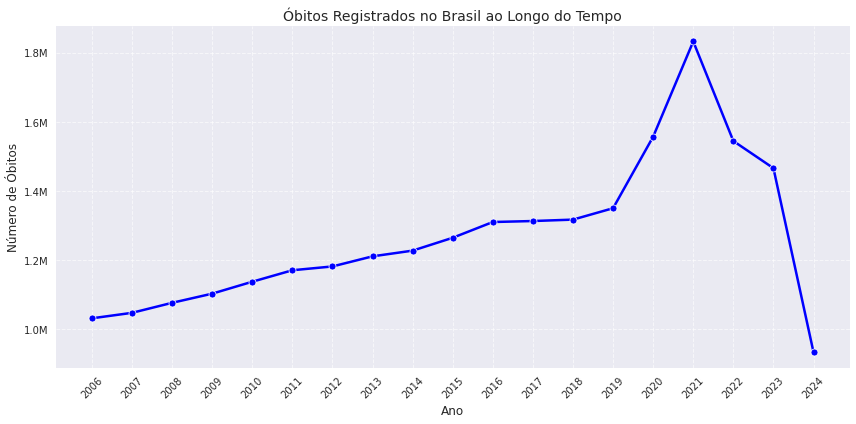

In [0]:
# Converter _sqldf para Pandas DataFrame
df_pandasq1 = _sqldf.toPandas()

# Criando o gráfico
plt.style.use('seaborn')
plt.figure(figsize=(12,6))
ax = sns.lineplot(data=df_pandasq1, x='ano', y='total_obitos', marker="o", linewidth=2.5, color='b')

# Função para formatar os valores do eixo Y
def format_y_axis(x, pos):
    if x >= 1e6:
        return f'{x*1e-6:.1f}M'
    if x >= 1e3:
        return f'{x*1e-3:.0f}k'
    return f'{x:.0f}'

# Aplicar a formatação personalizada ao eixo Y
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_y_axis))

plt.xlabel("Ano", fontsize=12)
plt.ylabel("Número de Óbitos", fontsize=12)
plt.title("Óbitos Registrados no Brasil ao Longo do Tempo", fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Discussão do resultado:

Com a análise gráfica, conseguimos ter uma noção melhor na distruibuição de óbitos ao longo dos anos no Brasil.

De 2006 a 2019, o número de óbitos cresceu de forma constante, podendo ser um reflexo do envelhecimento e aumento populacional do país.

Em 2020 e 2021, houve um pico significativo, muito provavelmente devido à pandemia de COVID-19. A partir de 2022, os óbitos começaram a diminuir com o controle da pandemia, embora os números ainda superem os níveis pré-pandemia.

2024 apresenta um número de óbitos menor, resultado de um período de dados incompletos / ainda não atualizados no dataset por parte do SIM (Sistema de Informação sobre Mortalidade), conforme mencionado na seção de explicação da coleta de dados.

Esse resultado nos mostra os impactos da pandemia e a importância do monitoramento contínuo da mortalidade para políticas de saúde públicas.

### 2. Quais são as principais causas de morte no Brasil? 

In [0]:
%sql
SELECT 
c.DESCRICAO AS causa_morte,
COUNT(m.CAUSABAS) AS total_obitos,
ROUND((COUNT(m.CAUSABAS) * 100.0 / (SELECT COUNT(*) FROM mortalidade_geral_gold)), 2) AS percentual

FROM
mortalidade_geral_gold AS m
LEFT JOIN cid_10_gold AS c ON (m.CAUSABAS = c.SUBCAT)

GROUP BY
c.DESCRICAO

ORDER BY
total_obitos DESC

LIMIT 10

causa_morte,total_obitos,percentual
Infarto agudo do miocárdio não especificado,1580020,6.57
Pneumonia não especificada,789684,3.28
Outras causas mal definidas e as não especificadas de mortalidade,773524,3.21
"Acidente vascular cerebral, não especificado como hemorrágico ou isquêmico",744658,3.09
Infecção por coronavírus de localização não especificada,716746,2.98
Diabetes mellitus não especificado - sem complicações,516386,2.15
Hipertensão essencial (primária),491294,2.04
"Neoplasia maligna dos brônquios ou pulmões, não especificado",453211,1.88
Morte sem assistência,331520,1.38
Agressão por meio de disparo de outra arma de fogo ou de arma não especificada - rua e estrada,320860,1.33


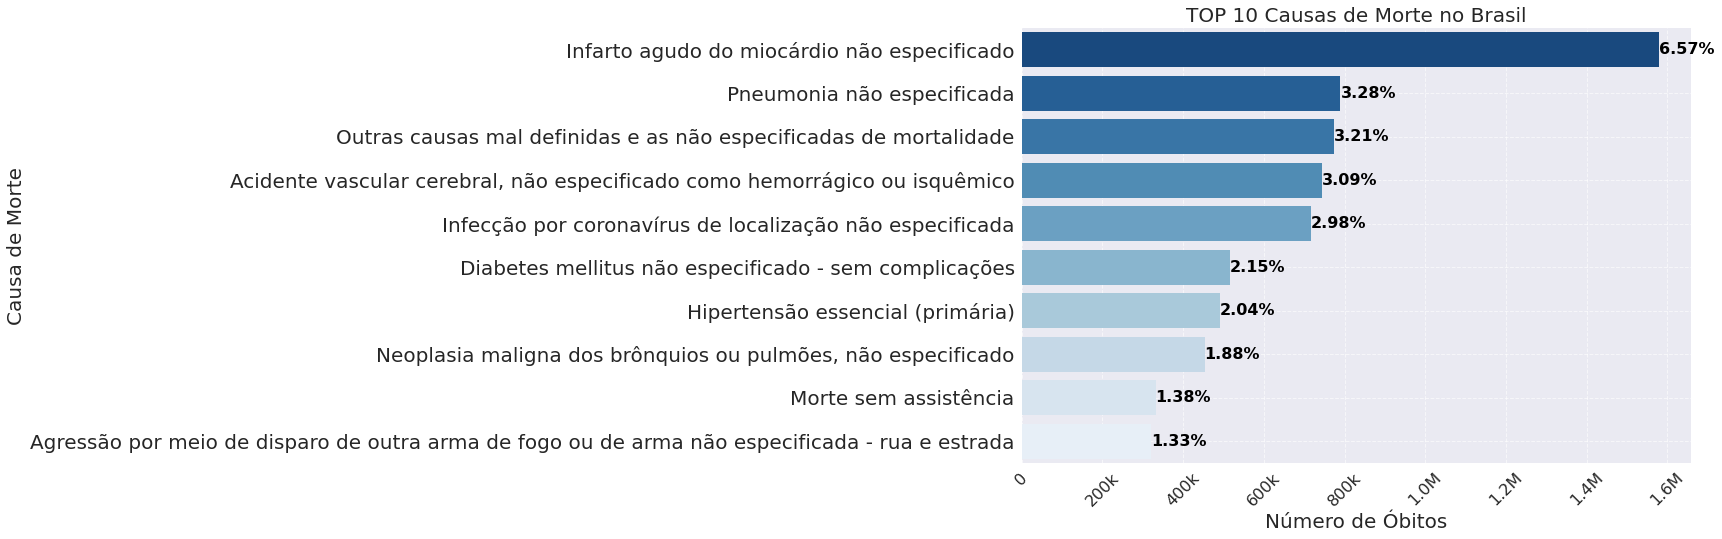

In [0]:
df_pandasq2 = _sqldf.toPandas()

# Criando o gráfico
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=df_pandasq2, x="total_obitos", y="causa_morte", palette="Blues_r")
ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)

# Função para formatar os valores do eixo X
def format_x_axis(x, pos):
    if x >= 1e6:
        return f'{x*1e-6:.1f}M'
    if x >= 1e3:
        return f'{x*1e-3:.0f}k'
    return f'{x:.0f}'

# Aplicar a formatação personalizada ao eixo X
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_x_axis))

# Adicionando rótulos com a porcentagem ao lado das barras
for i, (value, percent) in enumerate(zip(df_pandasq2["total_obitos"], df_pandasq2["percentual"])):
    ax.text(value, i, f"{percent:.2f}%", va="center", fontsize=16, color="black", fontweight="bold")

plt.xlabel("Número de Óbitos", fontsize=20)
plt.ylabel("Causa de Morte", fontsize=20)
plt.title("TOP 10 Causas de Morte no Brasil", fontsize=20)
plt.xticks(rotation=45, fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

A principal causa de morte no Brasil, de longe, é o infarto agudo do miocárdio, responsável por quase 1,6 milhão de óbitos desde 2006 (6,57%), indicando a relevância das doenças cardiovasculares. Em seguida, pneumonia não especificada e causas mal definidas também representam um grande número de mortes, evidenciando a necessidade de melhores diagnósticos.

A COVID-19 aparece em 5º lugar, com 2,98% dos casos, refletindo quão grande foi impacto da pandemia nos últimos anos.

Além disso, doenças crônicas como diabetes e hipertensão contribuem significativamente para a mortalidade, reforçando a importância da prevenção e do controle dessas condições.

O câncer de pulmão também se destaca, possivelmente relacionado ao tabagismo e à poluição. Por fim, a presença de mortes por arma de fogo e óbitos sem assistência pode indicar desafios na segurança pública e no acesso aos serviços de emergência.

Juntos, esse TOP 10 representam 27,91% de todas as causas de morte registradas no país desde 2006.

### 3. Qual a distribuição da mortalidade por faixa etária?

In [0]:
%sql
SELECT 
CASE 
    WHEN IDADE_GRUPO = 0 THEN 'Menos de 1 hora'
    WHEN IDADE_GRUPO = 1 THEN 'Menos de 1 dia'
    WHEN IDADE_GRUPO = 2 THEN 'Menos de 1 mês'
    WHEN IDADE_GRUPO = 3 THEN 'Menos de 1 ano'
    WHEN IDADE_GRUPO = 4 AND IDADE_QTD BETWEEN 0 AND 17 THEN '0-17 anos'
    WHEN IDADE_GRUPO = 4 AND IDADE_QTD BETWEEN 18 AND 29 THEN '18-29 anos'
    WHEN IDADE_GRUPO = 4 AND IDADE_QTD BETWEEN 30 AND 39 THEN '30-39 anos'
    WHEN IDADE_GRUPO = 4 AND IDADE_QTD BETWEEN 40 AND 49 THEN '40-49 anos'
    WHEN IDADE_GRUPO = 4 AND IDADE_QTD BETWEEN 50 AND 59 THEN '50-59 anos'
    WHEN IDADE_GRUPO = 4 AND IDADE_QTD BETWEEN 60 AND 69 THEN '60-69 anos'
    WHEN IDADE_GRUPO = 4 AND IDADE_QTD BETWEEN 70 AND 79 THEN '70-79 anos'
    WHEN IDADE_GRUPO = 4 AND IDADE_QTD BETWEEN 80 AND 89 THEN '80-89 anos'
    WHEN IDADE_GRUPO = 4 AND IDADE_QTD BETWEEN 90 AND 99 THEN '90-99 anos'
    WHEN IDADE_GRUPO = 5 THEN '100+ anos'
    ELSE 'Ignorado'
END AS faixa_etaria,
COUNT(*) AS total_obitos

FROM
mortalidade_geral_gold

GROUP BY
faixa_etaria

ORDER BY
CASE faixa_etaria
    WHEN 'Ignorado' THEN 1
    WHEN '100+ anos' THEN 2
    WHEN '90-99 anos' THEN 3
    WHEN '80-89 anos' THEN 4
    WHEN '70-79 anos' THEN 5
    WHEN '60-69 anos' THEN 6
    WHEN '50-59 anos' THEN 7
    WHEN '40-49 anos' THEN 8
    WHEN '30-39 anos' THEN 9
    WHEN '18-29 anos' THEN 10
    WHEN '0-17 anos' THEN 11
    WHEN 'Menos de 1 ano' THEN 12
    WHEN 'Menos de 1 mês' THEN 13
    WHEN 'Menos de 1 dia' THEN 14
    WHEN 'Menos de 1 hora' THEN 15
END

faixa_etaria,total_obitos
Ignorado,58772
100+ anos,160807
90-99 anos,1877639
80-89 anos,4698065
70-79 anos,4983091
60-69 anos,4080061
50-59 anos,2885508
40-49 anos,1795225
30-39 anos,1187789
18-29 anos,1184965


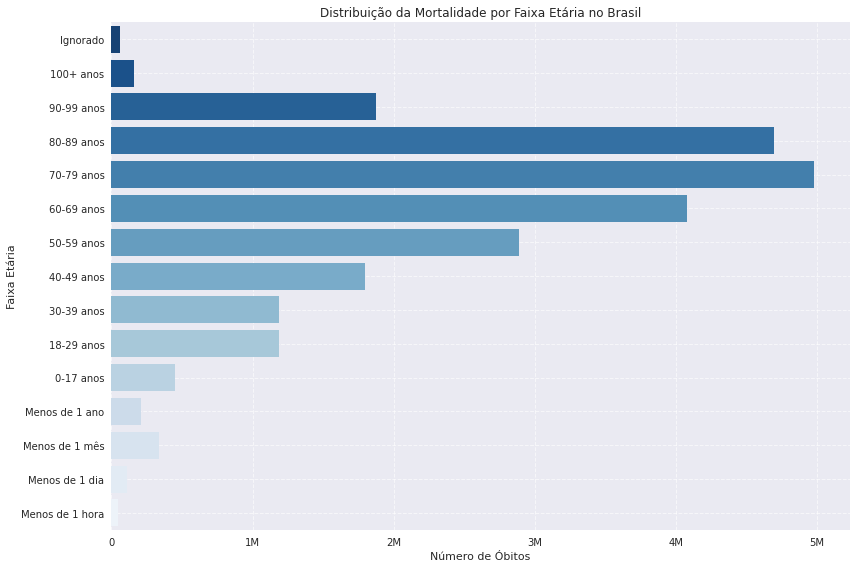

In [0]:
df_pandasq3 = _sqldf.toPandas()

# Criando o gráfico
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=df_pandasq3, x="total_obitos", y="faixa_etaria", palette="Blues_r")

# Função para formatar os valores do eixo X
def format_x_axis(x, pos):
    if x >= 1e6:
        return f'{x*1e-6:.0f}M'
    if x >= 1e3:
        return f'{x*1e-3:.0f}k'
    return f'{x:.0f}'

# Aplicar a formatação personalizada ao eixo X
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_x_axis))

plt.xlabel("Número de Óbitos")
plt.ylabel("Faixa Etária")
plt.title("Distribuição da Mortalidade por Faixa Etária no Brasil")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Através do gráfico vemos que o maior número de óbitos ocorre entre idosos, principalmente nas faixas de 60 a 89 anos, refletindo o impacto das doenças crônicas e do envelhecimento populacional, algo que vimos na análise da segunda pergunta. Isso é esperado, já que com o avanço da idade há uma maior predisposição a doenças e condições degenerativas.

No grupo de jovens e adultos (de 18 a 49 anos), os números de óbitos são bem menores, mas ainda expressivos. Nessa faixa etária, possíveis causas de morte podem ser acidentes de trânsito, homicídios e suicídios.

Entre crianças e bebês, os dados mostram um número relevante de óbitos em "Menos de 1 hora", "Menos de 1 dia" e "Menos de 1 mês", podendo indicar desafios no pré-natal ou parto. Já a faixa de "Menos de 1 ano" também se mantém significativa, podendo refletir problemas como infecções, desnutrição ou complicações congênitas.

Por fim, o grupo "Ignorado" indica casos onde a idade não foi corretamente informada, o que pode representar falhas no registro de dados ou dificuldades na identificação de vítimas.

### 4. Quais são as causas de morte mais comuns entre crianças, adultos e idosos?

In [0]:
%sql
SELECT
CASE 
    WHEN mg.IDADE_GRUPO IN (0, 1, 2) THEN 'Recém-nascido'
    WHEN mg.IDADE_GRUPO = 3 THEN 'Criança' 
    WHEN mg.IDADE_GRUPO = 4 AND mg.IDADE_QTD BETWEEN 0 AND 17 THEN 'Criança' 
    WHEN mg.IDADE_GRUPO = 4 AND mg.IDADE_QTD BETWEEN 17 AND 59 THEN 'Adulto' 
    WHEN mg.IDADE_GRUPO = 4 AND mg.IDADE_QTD >= 60 THEN 'Idoso' 
    WHEN mg.IDADE_GRUPO = 5 THEN 'Idoso'
    ELSE 'Ignorado'
END AS faixa_etaria,
c.DESCRICAO AS descricao_causa,
COUNT(*) AS total_obitos

FROM
mortalidade_geral_gold mg
LEFT JOIN cid_10_gold c ON (mg.CAUSABAS = c.SUBCAT)

WHERE
mg.IDADE_GRUPO IN (0, 1, 2)

GROUP BY
faixa_etaria, descricao_causa

ORDER BY
total_obitos DESC

LIMIT 3

faixa_etaria,descricao_causa,total_obitos
Recém-nascido,Septicemia bacteriana não especificada do recém-nascido,51126
Recém-nascido,Síndrome da angústia respiratória do recém-nascido,43226
Recém-nascido,Feto e recém-nascido afetados por transtornos maternos hipertensivos,15819


In [0]:
df_p4_1 = _sqldf

In [0]:
%sql
SELECT
CASE 
    WHEN mg.IDADE_GRUPO IN (0, 1, 2) THEN 'Recém-nascido'
    WHEN mg.IDADE_GRUPO = 3 THEN 'Criança' 
    WHEN mg.IDADE_GRUPO = 4 AND mg.IDADE_QTD BETWEEN 0 AND 17 THEN 'Criança' 
    WHEN mg.IDADE_GRUPO = 4 AND mg.IDADE_QTD BETWEEN 17 AND 59 THEN 'Adulto' 
    WHEN mg.IDADE_GRUPO = 4 AND mg.IDADE_QTD >= 60 THEN 'Idoso' 
    WHEN mg.IDADE_GRUPO = 5 THEN 'Idoso'
    ELSE 'Ignorado'
END AS faixa_etaria,
c.DESCRICAO AS descricao_causa,
COUNT(*) AS total_obitos

FROM
mortalidade_geral_gold mg
LEFT JOIN cid_10_gold c ON (mg.CAUSABAS = c.SUBCAT)

WHERE
(mg.IDADE_GRUPO = 3) OR (mg.IDADE_GRUPO = 4 AND mg.IDADE_QTD BETWEEN 0 AND 17)

GROUP BY
faixa_etaria, descricao_causa

ORDER BY
total_obitos DESC

LIMIT 3

faixa_etaria,descricao_causa,total_obitos
Criança,Agressão por meio de disparo de outra arma de fogo ou de arma não especificada - rua e estrada,31202
Criança,Pneumonia não especificada,26294
Criança,Outras causas mal definidas e as não especificadas de mortalidade,24450


In [0]:
df_p4_2 = _sqldf

In [0]:
%sql
SELECT
CASE 
    WHEN mg.IDADE_GRUPO IN (0, 1, 2) THEN 'Recém-nascido'
    WHEN mg.IDADE_GRUPO = 3 THEN 'Criança' 
    WHEN mg.IDADE_GRUPO = 4 AND mg.IDADE_QTD BETWEEN 0 AND 17 THEN 'Criança' 
    WHEN mg.IDADE_GRUPO = 4 AND mg.IDADE_QTD BETWEEN 17 AND 59 THEN 'Adulto' 
    WHEN mg.IDADE_GRUPO = 4 AND mg.IDADE_QTD >= 60 THEN 'Idoso' 
    WHEN mg.IDADE_GRUPO = 5 THEN 'Idoso'
    ELSE 'Ignorado'
END AS faixa_etaria,
c.DESCRICAO AS descricao_causa,
COUNT(*) AS total_obitos

FROM
mortalidade_geral_gold mg
LEFT JOIN cid_10_gold c ON (mg.CAUSABAS = c.SUBCAT)

WHERE
mg.IDADE_GRUPO = 4 AND mg.IDADE_QTD BETWEEN 17 AND 59

GROUP BY
faixa_etaria, descricao_causa

ORDER BY
total_obitos DESC

LIMIT 3

faixa_etaria,descricao_causa,total_obitos
Adulto,Infarto agudo do miocárdio não especificado,402279
Adulto,Agressão por meio de disparo de outra arma de fogo ou de arma não especificada - rua e estrada,280853
Adulto,Outras causas mal definidas e as não especificadas de mortalidade,275272


In [0]:
df_p4_3 = _sqldf

In [0]:
%sql
SELECT
CASE 
    WHEN mg.IDADE_GRUPO IN (0, 1, 2) THEN 'Recém-nascido'
    WHEN mg.IDADE_GRUPO = 3 THEN 'Criança' 
    WHEN mg.IDADE_GRUPO = 4 AND mg.IDADE_QTD BETWEEN 0 AND 17 THEN 'Criança' 
    WHEN mg.IDADE_GRUPO = 4 AND mg.IDADE_QTD BETWEEN 17 AND 59 THEN 'Adulto' 
    WHEN mg.IDADE_GRUPO = 4 AND mg.IDADE_QTD >= 60 THEN 'Idoso' 
    WHEN mg.IDADE_GRUPO = 5 THEN 'Idoso'
    ELSE 'Ignorado'
END AS faixa_etaria,
c.DESCRICAO AS descricao_causa,
COUNT(*) AS total_obitos

FROM
mortalidade_geral_gold mg
LEFT JOIN cid_10_gold c ON (mg.CAUSABAS = c.SUBCAT)

WHERE
(mg.IDADE_GRUPO = 4 AND mg.IDADE_QTD >= 60) OR (mg.IDADE_GRUPO = 5)

GROUP BY
faixa_etaria, descricao_causa

ORDER BY
total_obitos DESC

LIMIT 3

faixa_etaria,descricao_causa,total_obitos
Idoso,Infarto agudo do miocárdio não especificado,1175095
Idoso,Pneumonia não especificada,648652
Idoso,"Acidente vascular cerebral, não especificado como hemorrágico ou isquêmico",644800


In [0]:
df_p4_4 = _sqldf

In [0]:
df_p4 = df_p4_1.union(df_p4_2).union(df_p4_3).union(df_p4_4)

In [0]:
display(df_p4)

faixa_etaria,descricao_causa,total_obitos
Recém-nascido,Septicemia bacteriana não especificada do recém-nascido,51126
Recém-nascido,Síndrome da angústia respiratória do recém-nascido,43226
Recém-nascido,Feto e recém-nascido afetados por transtornos maternos hipertensivos,15819
Criança,Agressão por meio de disparo de outra arma de fogo ou de arma não especificada - rua e estrada,31202
Criança,Pneumonia não especificada,26294
Criança,Outras causas mal definidas e as não especificadas de mortalidade,24450
Adulto,Infarto agudo do miocárdio não especificado,402279
Adulto,Agressão por meio de disparo de outra arma de fogo ou de arma não especificada - rua e estrada,280853
Adulto,Outras causas mal definidas e as não especificadas de mortalidade,275272
Idoso,Infarto agudo do miocárdio não especificado,1175095


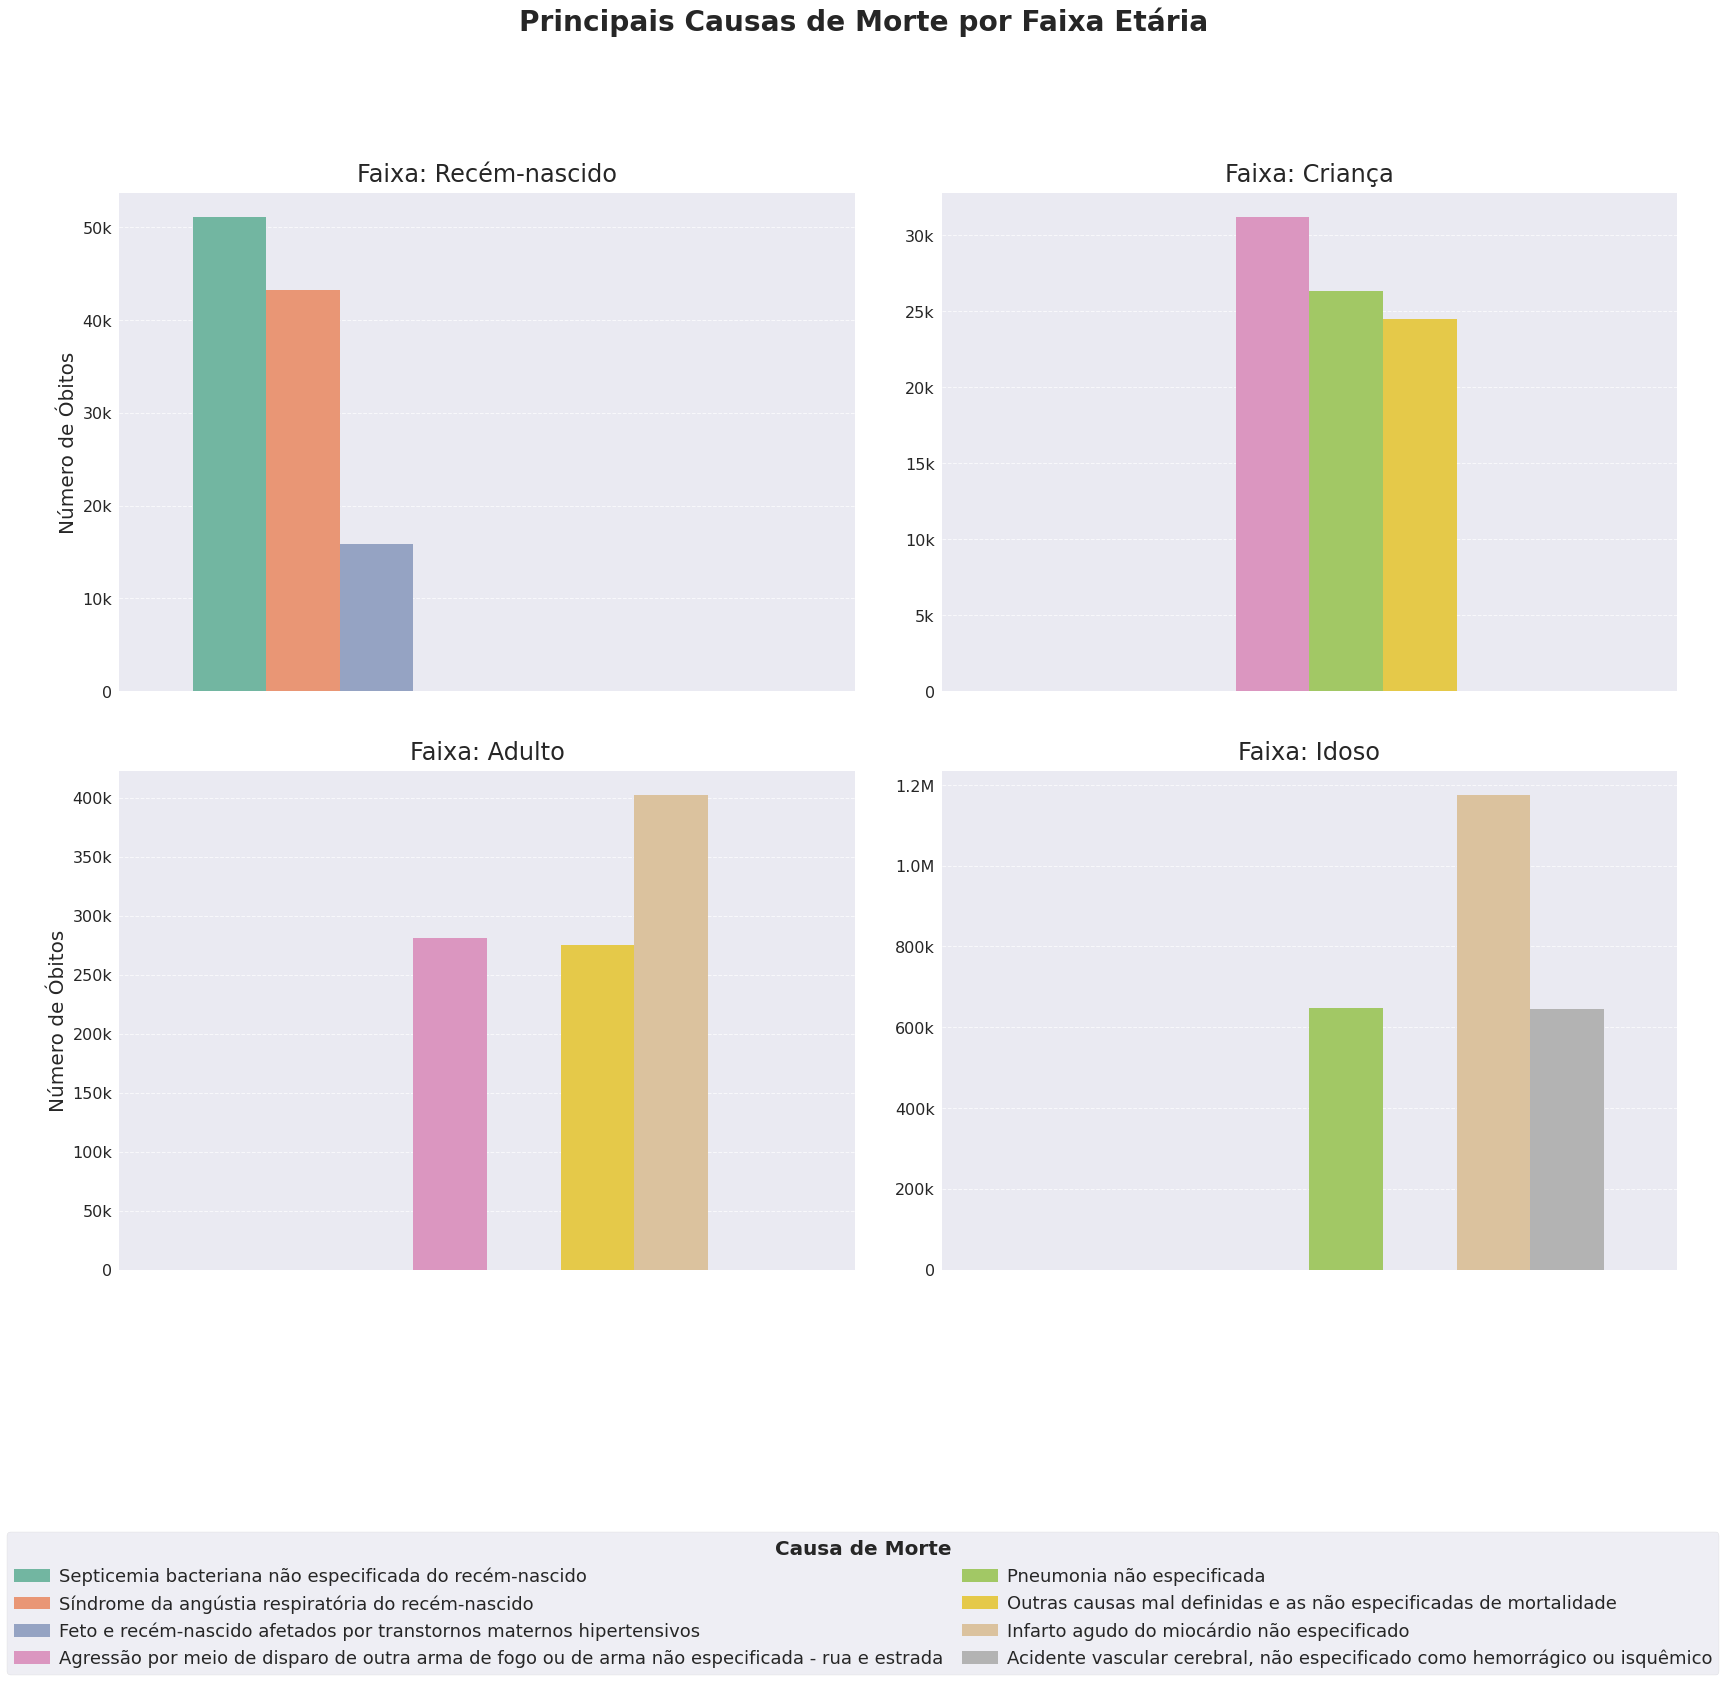

In [0]:
# Converter o DataFrame Spark para Pandas
df_pandas_p4 = df_p4.toPandas()

# Criar figura com 4 subplots (2 linhas, 2 colunas)
fig, axes = plt.subplots(2, 2, figsize=(24, 18))
fig.suptitle("Principais Causas de Morte por Faixa Etária", fontsize=28, y=1.02, fontweight='bold')

# Obter TODAS as descrições de causa únicas para a legenda completa
todas_causas = df_pandas_p4['descricao_causa'].unique()
palette = sns.color_palette("Set2", len(todas_causas))

# Obter as faixas etárias únicas
faixas_etarias = df_pandas_p4['faixa_etaria'].unique()

# Função para formatar os valores do eixo Y
def format_y_axis(x, pos):
    if x >= 1e6:
        return f'{x*1e-6:.1f}M'
    if x >= 1e3:
        return f'{x*1e-3:.0f}k'
    return f'{x:.0f}'

# Criar um gráfico para cada faixa etária
for i, faixa in enumerate(faixas_etarias):
    # Filtrar os dados para a faixa etária atual
    dados_faixa = df_pandas_p4[df_pandas_p4['faixa_etaria'] == faixa]
    
    # Criar o gráfico de barras no subplot correspondente
    sns.barplot(
        data=dados_faixa,
        x="faixa_etaria",
        y="total_obitos",
        hue="descricao_causa",
        palette=palette,
        hue_order=todas_causas,
        ax=axes.flat[i]
    )
    
    # Configurar cada subplot com fontes maiores
    axes.flat[i].set_title(f"Faixa: {faixa}", fontsize=24, pad=12)
    axes.flat[i].set_xlabel("", fontsize=20)
    axes.flat[i].set_ylabel("Número de Óbitos" if i in [0, 2] else "", fontsize=20)
    axes.flat[i].grid(axis="y", linestyle="--", alpha=0.7)
    axes.flat[i].tick_params(axis='both', which='major', labelsize=16)
    
    # Remover os ticks e labels do eixo X
    axes.flat[i].set_xticks([])
    axes.flat[i].set_xticklabels([])
    
    # Aplicar formatação personalizada ao eixo Y
    axes.flat[i].yaxis.set_major_formatter(plt.FuncFormatter(format_y_axis))
    
    # Remover a legenda de cada subplot individual
    axes.flat[i].get_legend().remove()

# Calcular o número de itens por linha na legenda
n_itens = len(todas_causas)
itens_por_linha = (n_itens + 3) // 4

# Criar uma legenda única com fontes maiores
handles, labels = axes.flat[0].get_legend_handles_labels()
legend = fig.legend(handles, labels, 
                   title="Causa de Morte", 
                   title_fontsize='20',
                   bbox_to_anchor=(0.5, -0.15),
                   loc="upper center", 
                   ncol=itens_por_linha,
                   fontsize=18,
                   frameon=True,
                   handletextpad=0.5,
                   columnspacing=1)

# Melhorar a legibilidade da legenda
plt.setp(legend.get_title(), fontweight='bold')

# Ajustar espaçamento entre subplots
plt.tight_layout(pad=5.0, h_pad=4.0, w_pad=4.0)

# Exibir o gráfico
plt.show()

Recém-nascidos:
Entre os recém-nascidos, as principais causas de morte estão relacionadas a complicações de saúde que geralmente surgem durante o parto ou logo após ele, assim como suspeitamos na análise da pergunta anterior. Além disso, fetos e recém-nascidos afetados por transtornos maternos hipertensivos (15.819 óbitos) indica que a saúde da mãe durante a gestação tem bastante importância na sobrevivência dos bebês.

Crianças:
Nas crianças, a agressão por disparo de arma de fogo (31.202 óbitos) ganha destaca, sinalizando um problema de violência infantil e questões relacionadas à segurança pública, assim como suspeitamos na análise da pergunta 2. A pneumonia não especificada (26.294 óbitos) e outras causas mal definidas (24.450 óbitos) estão entre as principais causas, evidenciando a necessidade de melhores diagnósticos em crianças, complementando o que também já foi analisado na pergunta 2.

Adultos:
Entre os adultos, o cenário de mortalidade é dominado por doenças cardiovasculares e violência. O infarto agudo do miocárdio se destaca como a principal causa de morte do país, como vimos na análise da pergunta 1, e aqui vemos que ela está centralizada na faixa dos adultos e dos idosos. Agressão por arma de fogo (280.853 óbitos) se repete na faixa para os adultos, o que reafirma uma preocupação com a violência urbana. As outras causas mal definidas e as não especificadas (275.272 óbitos) complementam a análise da necessidade de melhores diagnósticos para os óbitos.

Idosos:
Nos idosos, o infarto agudo do miocárdio (1.175.095 óbitos) retorna junto com a pneumonia (648.652 óbitos). A grande prevalência dessas doenças entre os idosos reflete a fragilidade do sistema imunológico com o tempo, o que é de se esperar. O AVC (644.800 óbitos), que é comum entre os mais velhos, também está entre as principais causas de morte, destacando problemas circulatórios na terceira idade.

### 5. O sexo das vítimas influencia as causas da morte?

In [0]:
%sql
SELECT 
s.DESCR_SEXO AS sexo,
c.DESCRICAO AS causa_morte,
COUNT(*) AS total_obitos,
ROUND((COUNT(*) * 100.0 / subquery.total_obitos2), 2) AS percentual

FROM
mortalidade_geral_gold mg
LEFT JOIN sexo_gold s ON (mg.SEXO = s.COD_SEXO)
LEFT JOIN cid_10_gold c ON (mg.CAUSABAS = c.SUBCAT)
JOIN (
        SELECT 
        c2.DESCRICAO AS causa_morte2,
        COUNT(m2.CAUSABAS) AS total_obitos2

        FROM
        mortalidade_geral_gold AS m2
        LEFT JOIN cid_10_gold AS c2 ON (m2.CAUSABAS = c2.SUBCAT)

        GROUP BY
        c2.DESCRICAO

        ORDER BY
        total_obitos2 DESC

        LIMIT 10
) subquery ON (c.DESCRICAO = subquery.causa_morte2)

WHERE
s.DESCR_SEXO <> 'Ignorado'

GROUP BY
s.DESCR_SEXO, c.DESCRICAO, subquery.total_obitos2

ORDER BY
sexo DESC, causa_morte ASC

sexo,causa_morte,total_obitos,percentual
Masculino,"Acidente vascular cerebral, não especificado como hemorrágico ou isquêmico",378880,50.88
Masculino,Agressão por meio de disparo de outra arma de fogo ou de arma não especificada - rua e estrada,306098,95.40
Masculino,Diabetes mellitus não especificado - sem complicações,223884,43.36
Masculino,Hipertensão essencial (primária),226397,46.08
Masculino,Infarto agudo do miocárdio não especificado,934371,59.14
Masculino,Infecção por coronavírus de localização não especificada,399691,55.76
Masculino,Morte sem assistência,190923,57.59
Masculino,"Neoplasia maligna dos brônquios ou pulmões, não especificado",265543,58.59
Masculino,Outras causas mal definidas e as não especificadas de mortalidade,467668,60.46
Masculino,Pneumonia não especificada,390207,49.41


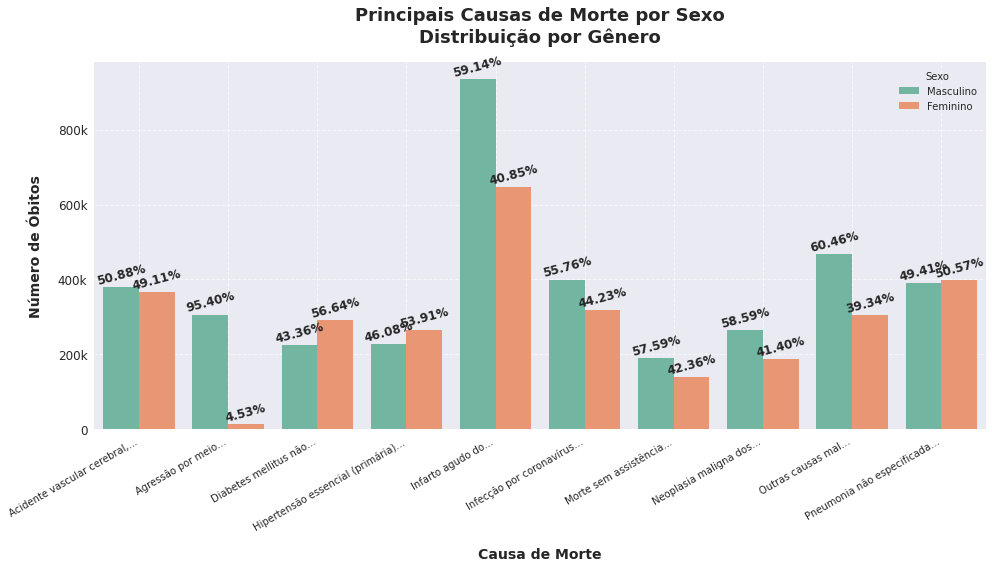

In [0]:
# Converter o DataFrame Spark para Pandas
df_pandas_p5 = _sqldf.toPandas()

# Criar gráfico de barras agrupado
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=df_pandas_p5, x="causa_morte", y="total_obitos", hue="sexo", palette="Set2")

# Adicionar porcentagens
for i, p in enumerate(ax.patches):
    # Pegar os valores diretamente na ordem do DataFrame
    row = df_pandas_p5.iloc[i]
    ax.text(p.get_x() + p.get_width()/2, 
            p.get_height(),
            f'{row["percentual"]:.2f}%', 
            ha='center', 
            va='bottom',
            fontsize=12,
            fontweight='bold',
            rotation=15)

# Função para formatar o eixo Y
def format_y_axis(x, pos):
    if x >= 1e6:
        return f'{x*1e-6:.1f}M'
    if x >= 1e3:
        return f'{x*1e-3:.0f}k'
    return f'{x:.0f}'

# Aplicar formatação ao eixo Y
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_y_axis))

# Encurtar os rótulos do eixo X (mostrar apenas as primeiras palavras)
short_labels = [' '.join(label.get_text().split()[:3]) + '...' for label in ax.get_xticklabels()]
ax.set_xticklabels(short_labels)

# Ajustes básicos
plt.title("Principais Causas de Morte por Sexo\nDistribuição por Gênero", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Causa de Morte", fontsize=14, fontweight='bold', labelpad=15)
plt.ylabel("Número de Óbitos", fontsize=14, fontweight='bold', labelpad=15)
plt.xticks(rotation=30, ha='right')
plt.yticks(fontsize=12)
plt.legend(title="Sexo", loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
sns.despine(left=True, bottom=True)
plt.show()

O infarto agudo do miocárdio, maior causa de morte no país, possui uma maior incidência entre os homens, com 59,14% para o sexo masculino, contra 40,85% para o sexo feminino.

O índice de violência, representado por mortes com armas de fogo, também afetam mais os homens, porém com uma proporção muito maior: 95,40% dos óbitos, contra 4,53% para nas mulheres!

O impacto da infecção por coronavírus é significativo para ambos os sexos, porém um pouco maior nos homens.

Câncer de pulmão também possui mais incidência nos homens, podendo indicar que homens fumam mais, por exemplo.

Mortes sem assistência e causas não especificadas também tendem a ocorrer mais no sexo masculino.

Para o lado das mulheres, ficaram duas principais causas de morte: diabetes e hipertensão. Essas duas doenças afetam mais as mulheres (65,64% e 53,91%, respectivamente), refletindo o impacto de condições crônicas de longo prazo no sexo feminino.

O resto das causas de morte estão bem equiparadas, com números bem próximos de 50% para cada sexo.

Obs.: A diferença entre a soma das porcentagens dos dois sexos e 100% está no "sexo ignorado", que não foi mostrado nos resultados pois eram valor insignificantes.

### 6. Houve mudanças na principal causas de morte ao longo do tempo?

In [0]:
%sql
SELECT 
ano,
rank,
causa_morte,
total_obitos

FROM (
    SELECT 
    SUBSTRING(mg.DTOBITO, 1, 4) AS ano,
    c.DESCRICAO AS causa_morte,
    COUNT(*) AS total_obitos,
    ROW_NUMBER() OVER (
        PARTITION BY SUBSTRING(mg.DTOBITO, 1, 4) 
        ORDER BY COUNT(*) DESC
    ) AS rank
    FROM 
    mortalidade_geral_gold mg
    JOIN cid_10_gold c ON (mg.CAUSABAS = c.SUBCAT)
    
    GROUP BY 
    SUBSTRING(mg.DTOBITO, 1, 4), c.DESCRICAO
) ranked_data

WHERE 
rank = 1

ORDER BY 
ano ASC

ano,rank,causa_morte,total_obitos
2006,1,Infarto agudo do miocárdio não especificado,68454
2007,1,Infarto agudo do miocárdio não especificado,70915
2008,1,Infarto agudo do miocárdio não especificado,74175
2009,1,Infarto agudo do miocárdio não especificado,75253
2010,1,Infarto agudo do miocárdio não especificado,78398
2011,1,Infarto agudo do miocárdio não especificado,81359
2012,1,Infarto agudo do miocárdio não especificado,82561
2013,1,Infarto agudo do miocárdio não especificado,84555
2014,1,Infarto agudo do miocárdio não especificado,85845
2015,1,Infarto agudo do miocárdio não especificado,89378


Para essa pergunta não é necessário nem mesmo um gráfico para verificarmos que não houve mudança na principal causa de morte, com excessão do ano de 2020 e 2021, onde a COVID-19 prevaleceu com valores bem acima do comum (212.681 em 2020 e 424.422 em 2021), mostrando o impacto gigantesco que a pandemia teve.

A partir de 2022, o infarto voltou a ser a principal causa de morte, indicando a redução do impacto da pandemia.

### 7. Qual é a proporção de óbitos que ocorreram em hospitais versus outros locais?

In [0]:
%sql
SELECT 
l.DESCR_LOCAL AS local_obito,
COUNT(*) AS total_obitos,
ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 2) AS percentual

FROM
mortalidade_geral_gold mg
LEFT JOIN local_obito_gold l ON (mg.LOCOCOR = l.COD_LOCAL)

GROUP BY
l.DESCR_LOCAL

ORDER BY
total_obitos DESC

local_obito,total_obitos,percentual
Hospital,16119889,66.99
Domicílio,4848198,20.15
Outros estabelecimentos de saúde,1216238,5.05
Via pública,1056595,4.39
Outros,785835,3.27
Ignorado,34723,0.14
Aldeia indígena,948,0.00


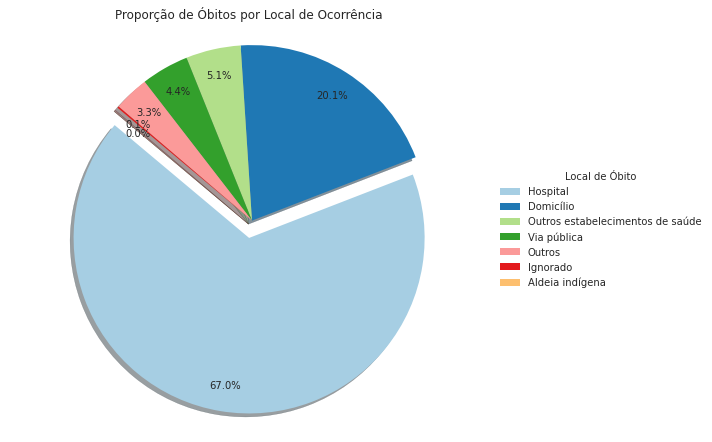

In [0]:
# Converter o DataFrame Spark para Pandas
df_pandas_p7 = _sqldf.toPandas()

# Criar gráfico de pizza
plt.figure(figsize=(10, 6))
colors = plt.cm.Paired.colors  # Paleta de cores
explode = (0.1, 0, 0, 0, 0, 0, 0)  # Destacar hospital

# Criar o gráfico sem legendas automáticas
wedges, _, autotexts = plt.pie(
    df_pandas_p7['total_obitos'], labels=[None] * len(df_pandas_p7),  # Remove labels diretas
    autopct='%1.1f%%', colors=colors, startangle=140, 
    explode=explode, shadow=True, labeldistance=1.05, pctdistance=0.85
)

# Ajustar manualmente a posição da porcentagem de "Aldeia indígena"
for autotext in autotexts:
    if autotext.get_text().strip() == "0.0%":  # Verifica o percentual correspondente
        x, y = autotext.get_position()
        autotext.set_position((x, y - 0.05))  # Move ligeiramente para baixo

# Criar legenda manual ao lado direito
plt.legend(wedges, df_pandas_p7['local_obito'], title="Local de Óbito", loc="center left", bbox_to_anchor=(1, 0.5))

# Ajustes no layout
plt.axis('equal')
plt.tight_layout()
plt.title("Proporção de Óbitos por Local de Ocorrência")

# Exibir o gráfico
plt.show()

A grande maioria dos óbitos ocorreu em hospitais (66.99%), o que reflete a predominância do atendimento hospitalar nos casos de falecimento, além de "Outros estabelecimentos de saúde" (5.05%) mostrar que, apesar de fora de um hosital, o paciente estava em local com condições mínimas de atendimento, não estando totalmente desamparado. 

Óbitos em domicílio (20.15%) também representam uma parcela significativa, o que pode estar associado a dificuldade de acesso aos hospitais ou mortes inesperadas.

Óbitos em via pública (4.39%) mostram que uma parte pequena dos falecimentos ocorre fora dos hospitais. Já as categorias "Outros" (3.27%), "Ignorado" (0.14%) e "Aldeia indígena" (0.00%) indicam registros menos frequentes.

### 8. Qual é a distribuição de óbitos por raça/cor?

In [0]:
%sql
SELECT 
c.DESCR_COR AS raca_cor,
COUNT(*) AS total_obitos,
ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 2) AS percentual

FROM mortalidade_geral_gold mg
LEFT JOIN cor_gold c ON (mg.RACACOR = c.COD_COR)

GROUP BY
c.DESCR_COR

ORDER BY
total_obitos DESC

raca_cor,total_obitos,percentual
Branca,12367158,51.40
Parda,8566105,35.60
Preta,1881968,7.82
Ignorado,1038490,4.32
Amarela,136349,0.57
Indígena,72356,0.30


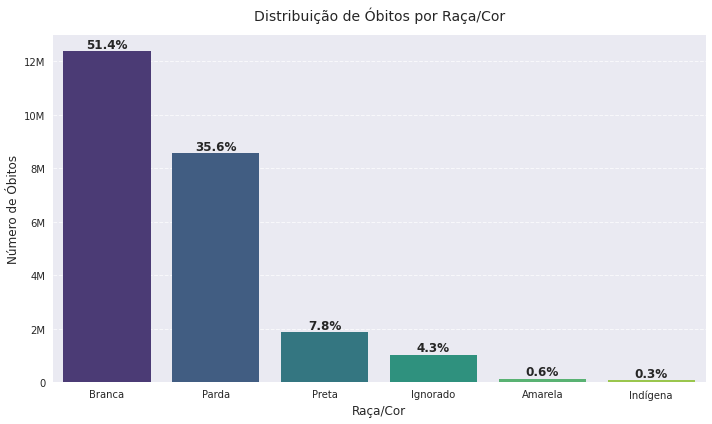

In [0]:
# Converter o DataFrame Spark para Pandas
df_pandas_p8 = _sqldf.toPandas()

# Criar gráfico de barras
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_pandas_p8, x="raca_cor", y="total_obitos", palette="viridis")

# Formatar eixo Y em "k" e "M"
def format_y_axis(x, pos):
    if x >= 1e6:
        return f'{x*1e-6:.0f}M'
    if x >= 1e3:
        return f'{x*1e-3:.0f}k'
    return f'{x:.0f}'
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_y_axis))

# Adicionar rótulos
plt.xlabel("Raça/Cor", fontsize=12)
plt.ylabel("Número de Óbitos", fontsize=12)
plt.title("Distribuição de Óbitos por Raça/Cor", fontsize=14, pad=15)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Exibir valores sobre as barras (mantendo porcentagens)
for index, row in df_pandas_p8.iterrows():
    plt.text(index, row.total_obitos, f"{row.percentual:.1f}%", 
             ha="center", va="bottom", fontsize=12, fontweight='bold')

# Ajustes finais
plt.tight_layout()
plt.show()

A maioria dos óbitos ocorreu entre pessoas brancas (51,4%) e pardas (35,6%), totalizando mais de 87% dos registros.

A população preta representou cerca de 7,82% dos óbitos, um número significativo, mas menor que os grupos anteriores.

O percentual de indígenas (0,30%) e amarelos (0,57%) é o menor, já que essas duas categorias estão em menor quantidade populacional mo país.

A discrepância entre a primeira colocada e as demais pode significar que existem um maior registro de pessoas com a raça "branca" nas certidões de nascimento, não necessariamente indicando que pessoas brancas tem uma longevidade menor ou são mais violentadas do que outras raças.

### 9. O estado civil tem relação com a mortalidade?

In [0]:
%sql
SELECT 
ec.DESCR_ESTADO AS estado_civil,
COUNT(*) AS total_obitos,
ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 2) AS percentual

FROM
mortalidade_geral_gold mg
LEFT JOIN estado_civil_gold ec ON (mg.ESTCIV = ec.COD_ESTCIVIL)

GROUP BY
ec.DESCR_ESTADO

ORDER BY
total_obitos DESC

estado_civil,total_obitos,percentual
Casado,7905301,32.85
Solteiro,6120703,25.44
Viúvo,5556896,23.09
Ignorado,2511231,10.44
Separado judicialmente/divorciado,1411398,5.87
União estável,556897,2.31


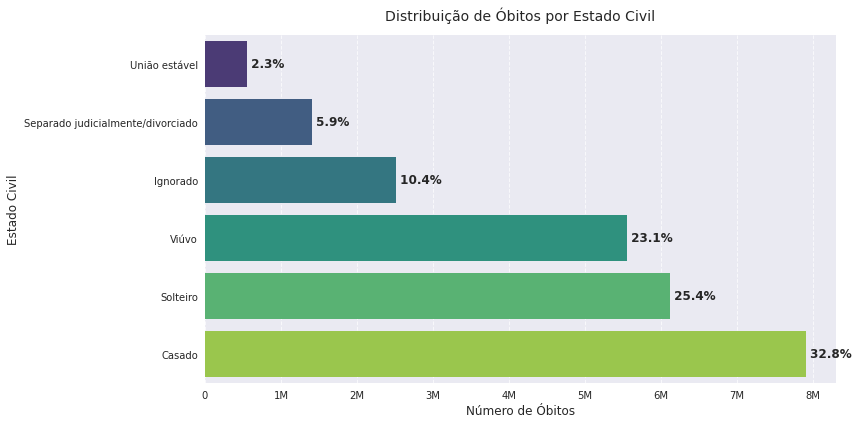

In [0]:
# Converter o DataFrame Spark para Pandas
df_pandas_p9 = _sqldf.toPandas()

# Ordenar do maior para o menor
df_pandas_p9 = df_pandas_p9.sort_values(by="total_obitos", ascending=True)

# Criar gráfico de barras horizontais
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_pandas_p9, x="total_obitos", y="estado_civil", palette="viridis")

# Formatar eixo X em "k" e "M"
def format_x_axis(x, pos):
    if x >= 1e6:
        return f'{x*1e-6:.0f}M'
    if x >= 1e3:
        return f'{x*1e-3:.0f}k'
    return f'{x:.0f}'
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_x_axis))

# Adicionar rótulos
plt.xlabel("Número de Óbitos", fontsize=12)
plt.ylabel("Estado Civil", fontsize=12)
plt.title("Distribuição de Óbitos por Estado Civil", fontsize=14, pad=15)
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Exibir valores sobre as barras (ajustado para gráfico horizontal)
for index, row in enumerate(df_pandas_p9.itertuples()):
    plt.text(row.total_obitos, index, f" {row.percentual:.1f}%", 
             ha="left", va="center", fontsize=12, fontweight='bold')

# Ajustes finais
plt.tight_layout()
plt.show()

O maior número de óbitos ocorre entre pessoas casadas (32,85%), o que pode ser explicado pelo fato de pessoas casadas tendem a ser mais velhas, o que aumenta a probabilidade de mortalidade. Essa análise poderia ser verificada se fizermos uma consulta agrupada por estado civil e idade, e então verificaríamos se realmente pessoas com estado casado estão nos grupos com maiores idades.

Para os solteiros (25,44%), a causa pode estar associada a estilos de vida menos saudáveis, pois estudos indicam que pessoas solteiras, em média, maior propensão a fatores de risco como tabagismo e consumo excessivo de álcool. Isso poderia ser analisado fazendo uma consulta agrupada por estado civil e causa da morte, e então poderímos ver se essa suposição é real, justificando a essa alta taxa de mortalidade. 

Viúvos (23,09%) também possuem alta mortalidade, porém se encaixam em um quadro semelhante aos casados: como o falecimento do cônjuge geralmente ocorre em idades mais avançadas, é esperado que o risco de mortalidade por conta do envelhecimento seja maior.

Pessoas divorciadas ou separadas judicialmente correspondem a 5,87% dos óbitos, enquanto aqueles em união estável representam apenas 2,31%. Esses grupos podem ter um perfil etário mais jovem em relação a casados e viúvos, reduzindo a mortalidade.

10,44% dos registros têm estado civil "ignorado", podendo indicar dificuldades em obter essa informação em determinados contextos, por exemplo, óbitos sem familiares próximos para informar o estado civil.

### 10. Quais locais apresentam as maiores taxas de mortalidade?

In [0]:
%sql
SELECT 
m.MUNICIPIO AS nome_municipio,
m.UF AS estado,
COUNT(*) AS total_obitos

FROM mortalidade_geral_gold mg
LEFT JOIN municipios_gold m ON (mg.CODMUNOCOR = m.CODMUN)

GROUP BY
m.MUNICIPIO, m.UF

ORDER BY
total_obitos DESC

LIMIT 10

nome_municipio,estado,total_obitos
São Paulo,SP,1590877
Rio de Janeiro,RJ,1198392
Recife,PE,434786
Belo Horizonte,MG,407671
Salvador,BA,389352
Fortaleza,CE,378894
Porto Alegre,RS,311350
Brasília,DF,273696
Curitiba,PR,263763
Goiânia,GO,257890


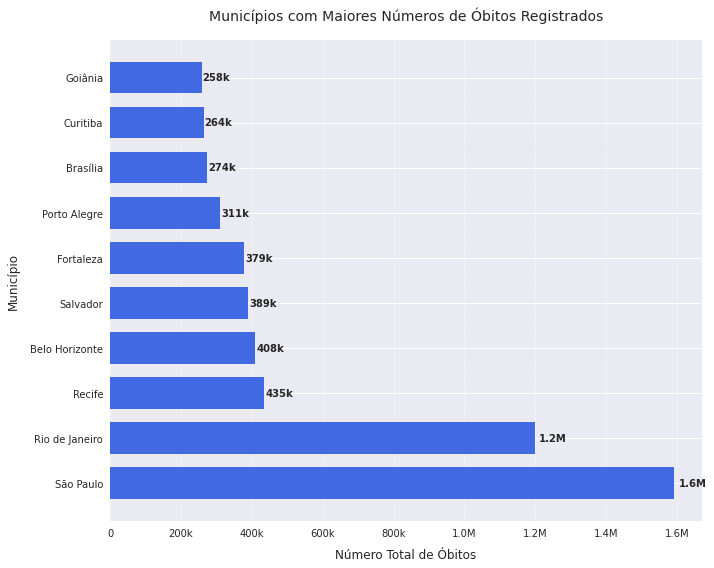

In [0]:
# Converter o DataFrame Spark para Pandas
df_pandas_p10 = _sqldf.toPandas()

# Criando o gráfico
plt.figure(figsize=(12, 8))
bars = plt.barh(df_pandas_p10["nome_municipio"], df_pandas_p10["total_obitos"], color="royalblue", height=0.7)

# Função para formatar os valores
def format_value(x):
    if x >= 1e6:
        return f'{x/1e6:.1f}M'
    if x >= 1e3:
        return f'{x/1e3:.0f}k'
    return f'{x:.0f}'

# Formatar eixo X
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: format_value(x)))

# Ajustes no layout
plt.xlabel("Número Total de Óbitos", fontsize=12, labelpad=10)
plt.ylabel("Município", fontsize=12, labelpad=10)
plt.title("Municípios com Maiores Números de Óbitos Registrados", fontsize=14, pad=20)
plt.grid(axis="x", linestyle="--", alpha=0.5)

# Exibir os valores formatados nas barras
for bar in bars:
    width = bar.get_width()
    plt.text(width + width*0.01,  # Posiciona à direita da barra com pequeno offset
             bar.get_y() + bar.get_height()/2,  # Centraliza verticalmente
             format_value(width),  # Valor formatado
             va='center', ha='left', 
             fontsize=10, fontweight='bold')

# Melhorar a legibilidade dos rótulos Y
plt.yticks(fontsize=10)

# Ajustar margens
plt.tight_layout()
plt.subplots_adjust(left=0.3)  # Espaço para nomes longos de municípios

plt.show()

Os municípios com maior número de óbitos são as capitais de estados populosos, indicando a relação direta entre densidade populacional e o número total de mortes.

São Paulo e Rio de Janeiro lideram com ampla margem em relação aos demais, provavelmente devido ao tamanho da população e à presença de grandes hospitais que recebem pacientes de outras regiões, porém também existe a alta criminalidade associada a esses estados, principalmente o Rio de Janeiro. Para verificarmos se essa suposição é válida, poderíamos fazer uma consulta agrupada por causa da morte, e então verificaríamos se mortes por arma de fogo, por exemplo, estão nas principais causas de morte nesses municípios. 

Municípios do Nordeste e Sul também se destacam: Recife, Salvador e Fortaleza mostram números expressivos, refletindo grandes populações e possíveis fatores sociais e estruturais.

Mesmo sem ser o estado mais populoso, Brasília se destaca, possivelmente devido a uma concentração de serviços de saúde que atende pessoas de toda a região.

Para melhorar essa análise, poderíamos:

- fazer consultas buscando a taxa de mortalidade por 100 mil habitantes, permitindo comparar cidades de tamanhos diferentes de maneira mais justa;

- Fazer consultas por causas de morte mais frequentes por município, para verificar reais motivos de taxas de mortalidade altas em determinados locais;

- Fazer consultas por faixa etária por município, para verificar se algumas cidades têm mortalidade maior devido ao envelhecimento populacional.

### 11. Em quais horários ocorrem mais mortes?

In [0]:
%sql
SELECT 
LEFT(HORAOBITO, 2) AS hora,  -- Extrai apenas a hora (HH) do campo HORAOBITO
COUNT(*) AS total_obitos,
ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 2) AS percentual

FROM mortalidade_geral_gold

WHERE
HORAOBITO IS NOT NULL

GROUP BY
LEFT(HORAOBITO, 2)

ORDER BY
hora ASC

hora,total_obitos,percentual
00,830773,3.64
01,807196,3.53
02,788793,3.45
03,792535,3.47
04,851828,3.73
05,986803,4.32
06,1061421,4.65
07,944645,4.13
08,1035297,4.53
09,1050051,4.60


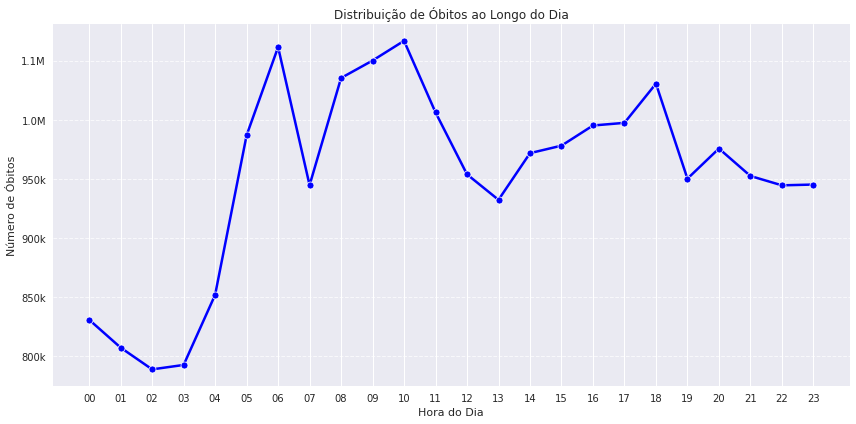

In [0]:
# Converter o DataFrame Spark para Pandas
df_pandas_p11 = _sqldf.toPandas()

# Criar gráfico de linha
plt.figure(figsize=(12, 6))
ax = sns.lineplot(x=df_pandas_p11["hora"], y=df_pandas_p11["total_obitos"], marker='o', linewidth=2.5, color='b')

# Formatar eixo Y em "k" e "M"
def format_y_axis(x, pos):
    if x >= 1e6:
        return f'{x*1e-6:.1f}M'
    if x >= 1e3:
        return f'{x*1e-3:.0f}k'
    return f'{x:.0f}'
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_y_axis))

# Ajustes no layout
plt.xlabel("Hora do Dia")
plt.ylabel("Número de Óbitos")
plt.title("Distribuição de Óbitos ao Longo do Dia")
plt.xticks(df_pandas_p11["hora"])
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Exibir gráfico
plt.tight_layout()
plt.show()

Os dados mostram que os óbitos estão mais concentrados no período da manhã, especialmente entre 6h e 11h, com pico às 10h. Possíveis explicações poderiam ser que estudos sugerem que infartos e AVCs são mais comuns pela manhã devido a picos de pressão arterial e mudanças hormonais. Isso faz sentido com nossos dados, pois vimos que essas duas causas de morte estão entre as que mais ocorrem no Brasil.

Os números caem após o meio-dia e voltam a subir levemente no final da tarde, por volta das 18h, possivelmente devido a acidentes de trânsito, já que há um grande fluxo de veículos nesse horário. Seria válido fazer uma query agrupada por hora do acidente e causa da morte, para verificarmos se essa suposição é verdadeira.

### 12. A taxa de homicídios aumentou ou diminuiu ao longo dos anos?

In [0]:
%sql
SELECT 
SUBSTRING(DTOBITO, 1, 4) AS ano,  -- Extrai o ano da data do óbito
COUNT(*) AS total_homicidios

FROM
mortalidade_geral_gold

WHERE
CIRCOBITO = '3'  -- Filtra apenas homicídios

GROUP BY
SUBSTRING(DTOBITO, 1, 4)

ORDER BY
ano

ano,total_homicidios
2006,46105
2007,45517
2008,47719
2009,48755
2010,49503
2011,49786
2012,53817
2013,54423
2014,57300
2015,55824


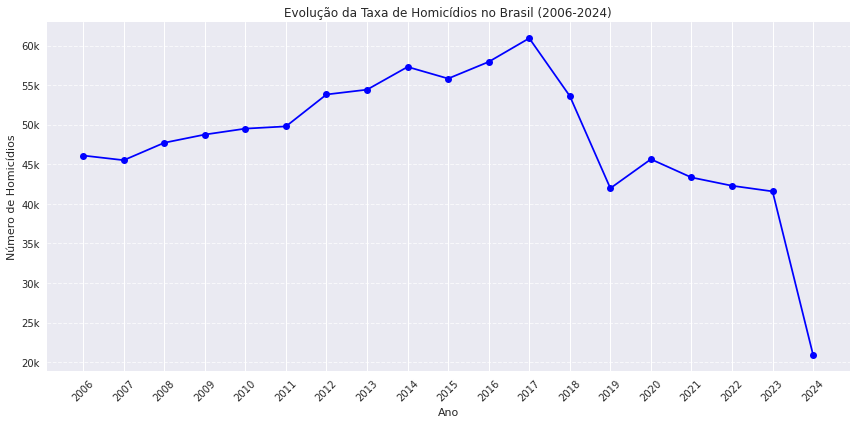

In [0]:
# Converter o DataFrame Spark para Pandas
df_pandas_p12 = _sqldf.toPandas()

# Criar gráfico de linha
plt.figure(figsize=(12, 6))
plt.plot(df_pandas_p12['ano'], df_pandas_p12['total_homicidios'], marker='o', linestyle='-', color='b')

# Formatar eixo Y em "k" e "M"
def format_y_axis(x, pos):
    if x >= 1e6:
        return f'{x/1e6:.1f}M'
    if x >= 1e3:
        return f'{x/1e3:.0f}k'
    return f'{x:.0f}'
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_y_axis))

# Ajustes no layout
plt.xlabel("Ano")
plt.ylabel("Número de Homicídios")
plt.title("Evolução da Taxa de Homicídios no Brasil (2006-2024)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

Entre 2006 e 2017, o número de homicídios aumentou de 46.105 para 60.918, atingindo o pico histórico em 2017. A partir de 2018, há uma queda expressiva, chegando a 41.973 homicídios em 2019.

Em 2020, durante a pandemia, houve um aumento para 45.642 homicídios, enquanto nos anos seguintes (2021-2023), o número voltou a cair gradualmente.

Em 2024, o total de homicídios registrado até o momento é 20.924. Porém é um resultado de um período de dados incompletos / ainda não atualizados no dataset por parte do SIM (Sistema de Informação sobre Mortalidade), conforme mencionado na seção de explicação da coleta de dados.

Podemos concluir que a taxa de homicídios vem diminuindo com o tempo, pois veio de uma crescente de 2006-2017, mas de 2018 até agora, a taxa só diminui.

### 13. Quais regiões apresentam maior incidência de suicídios?

In [0]:
%sql
SELECT 
m.UF AS estado,
COUNT(*) AS total_suicidios

FROM
mortalidade_geral_gold mg
LEFT JOIN municipios_gold m ON (mg.CODMUNOCOR = m.CODMUN)

WHERE
mg.CIRCOBITO = '2'  -- Filtra apenas os casos de suicídio

GROUP BY
m.UF

ORDER BY
total_suicidios DESC

LIMIT 10

estado,total_suicidios
SP,38645
MG,24640
RS,23174
PR,14024
SC,11924
CE,10730
RJ,10117
BA,9996
GO,8387
PE,6888


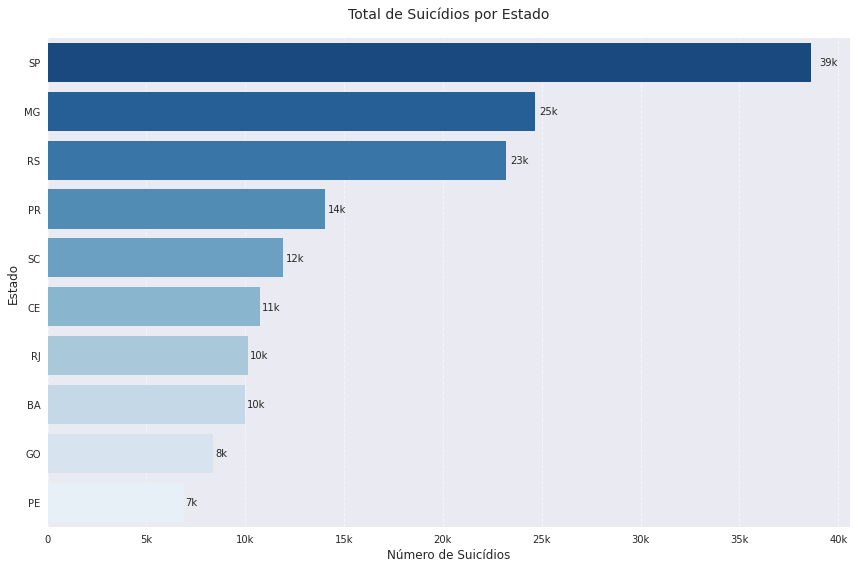

In [0]:
# Converter o DataFrame Spark para Pandas
df_pandas_p13 = _sqldf.toPandas()

# Criar gráfico de barras horizontais
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=df_pandas_p13['total_suicidios'], y=df_pandas_p13['estado'], palette="Blues_r")

# Formatar eixo X em "k" e "M"
def format_x_axis(x, pos):
    if x >= 1e6:
        return f'{x/1e6:.1f}M'
    if x >= 1e3:
        return f'{x/1e3:.0f}k'
    return f'{x:.0f}'
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_x_axis))

# Ajustes no layout
plt.xlabel("Número de Suicídios", fontsize=12)
plt.ylabel("Estado", fontsize=12)
plt.title("Total de Suicídios por Estado", fontsize=14, pad=20)
plt.grid(axis="x", linestyle="--", alpha=0.5)

# Adicionar valores nas barras
for p in ax.patches:
    width = p.get_width()
    ax.text(width + width*0.01,
            p.get_y() + p.get_height()/2,
            format_x_axis(width, None),
            va='center', ha='left', 
            fontsize=10)

plt.tight_layout()
plt.show()

O sudeste lidera o ranking com São Paulo e Minas Gerais, com o estado de São Paulo registrando 38.645 suicídios de 2006 até 2024, sendo o mais alto do país. Isso pode estar relacionado ao tamanho populacional ou aos desafios sociais que podem impactar na saúde mental.

Os estados do Rio Grande do Sul (23.174), Paraná (14.024) e Santa Catarina (11.924) aparecem entre os cinco primeiros, sendo todos eles do Sul. Essa alta incidência pode estar associada a fatores como invernos rigorosos e a cultura de menor interação social, podendo influenciar no psicológico da pessoas.

O Ceará (10.730) lidera no Nordeste, seguido da Bahia (9.996) e de Pernambuco (6.888). No Centro-Oeste, Goiás (8.387) aparece em nono lugar.

### 14. Qual é a distribuição de óbitos por causas relacionadas ao trabalho?

In [0]:
%sql
SELECT
c.DESCRICAO AS causa_morte,
COUNT(*) AS total_obitos,
ROUND((COUNT(mg.CAUSABAS) * 100.0 / (SELECT COUNT(*) FROM mortalidade_geral_gold WHERE ACIDTRAB = 'Sim')), 2) AS percentual

FROM
mortalidade_geral_gold mg
LEFT JOIN cid_10_gold c ON (mg.CAUSABAS = c.SUBCAT)

WHERE
mg.ACIDTRAB = 'Sim'

GROUP BY
c.DESCRICAO

ORDER BY
total_obitos DESC

LIMIT 10

causa_morte,total_obitos,percentual
Pessoa traumatizada em um acidente de trânsito com um veículo a motor não especificado,2872,4.50
"Ocupante [qualquer] de um automóvel [carro], traumatizado em um acidente de trânsito não especificado",2007,3.15
Exposição a corrente elétrica não especificada - local não especificado,1608,2.52
"Motociclista traumatizado em colisão com um automóvel [carro], ""pick up"" ou caminhonete - condutor traumatizado em um acidente de trânsito",1444,2.26
Ocupante de um veículo de transporte pesado traumatizado em um acidente de transporte sem colisão - condutor [motorista] traumatizado em um acidente de trânsito,1425,2.23
Exposição a fator não especificado causando outro tr|aumatismo e traumatismo não especificado,1274,2.00
Motociclista traumatizado em colisão com um veículo de transporte pesado ou um ônibus - condutor traumatizado em um acidente de trânsito,1063,1.67
Ocupante de um veículo de transporte pesado traumatizado em colisão com um outro veículo de transporte pesado ou um ônibus - condutor [motorista] traumatizado em um acidente de trânsito,1042,1.63
Queda de ou para fora de edifícios ou outras estruturas - local não especificado,1001,1.57
"Impacto causado por objeto lançado, projetado ou em queda - local não especificado",988,1.55


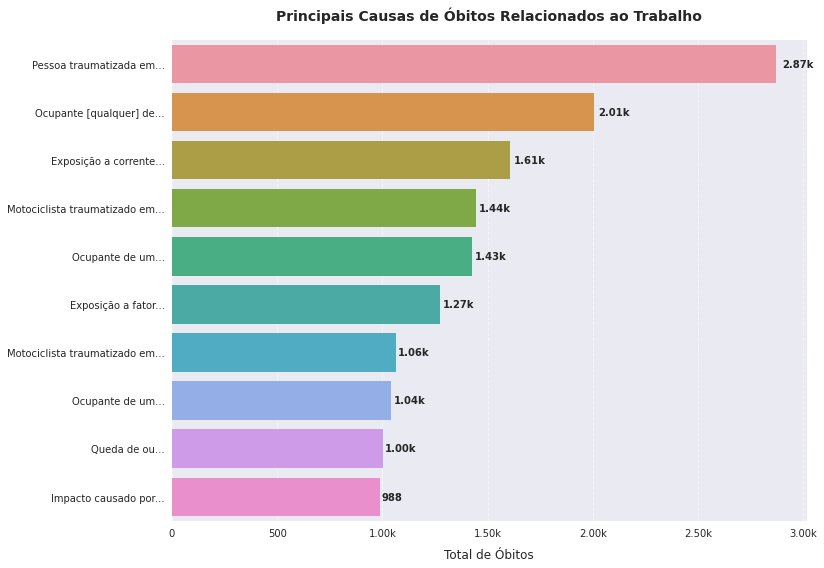

In [0]:
# Converter o DataFrame Spark para Pandas
df_pandas_p14 = _sqldf.toPandas()

# Criar gráfico de barras horizontais
plt.style.use('seaborn')
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='total_obitos', y='causa_morte', data=df_pandas_p14)

# Função para formatar os valores
def format_value(x):
    if x >= 1e6:
        return f'{x/1e6:.1f}M'
    if x >= 1e3:
        return f'{x/1e3:.2f}k'
    return f'{x:.0f}'

# Formatar eixo X
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: format_value(x)))

# Encurtar os rótulos do eixo Y
short_labels = [' '.join(label.get_text().split()[:3]) + '...' for label in ax.get_yticklabels()]
ax.set_yticklabels(short_labels)

# Ajustes no layout
plt.xlabel("Total de Óbitos", fontsize=12, labelpad=10)
plt.ylabel("") 
plt.title("Principais Causas de Óbitos Relacionados ao Trabalho", fontsize=14, pad=20, fontweight='bold')
plt.grid(axis="x", linestyle="--", alpha=0.5)

# Exibir valores formatados nas barras
for index, patch in enumerate(ax.patches):
    width = patch.get_width()
    ax.text(width + width*0.01,
            patch.get_y() + patch.get_height()/2,
            format_value(width),
            va='center', ha='left', 
            fontsize=10,
            fontweight='bold')

# Ajustar margens
plt.tight_layout()
plt.subplots_adjust(left=0.35)

plt.show()

A maioria das mortes relacionadas ao trabalho está associada a acidentes de trânsito, possuindo 6 causas de mortes diferentes no TOP10. Elas estão principalmente envolvendo veículos automotores, motociclistas e veículos de transporte pesado, nos mostrando a necessidade de melhorias de segurança no transporte, como melhores sinalizações de trânsito.

A exposição a corrente elétrica e quedas de edifícios também aparecem entre as principais causas, estando em 3º e 9º lugares, respectivamente. Isso sugere a necessidade de treinamentos de segurança e equipamentos adequados para trabalhadores em setores como construção civil e manutenção elétrica.

Ocorrências como impactos de objetos e exposição a fatores não especificados indicam riscos variados no ambiente de trabalho, exigindo inspeções regulares e adoção de medidas preventivas.

### Discussão geral

Alcançamos nosso objetivo com esse projeto ao consolidar e tornar acessíveis os dados de mortalidade no Brasil, permitindo a identificação de tendências e fatores relevantes para a saúde pública. As análises revelaram padrões como o impacto da COVID-19, o crescimento constante dos óbitos ao longo dos anos, e a predominância de doenças cardiovasculares como principal causa de morte.

Também vimos que a maioria dos óbitos ocorreram em hospitais, além de destacarmos as desigualdades por sexo, idade, raça e estado civil. Fatores como a violência e os estados e horários mais frequentes também foram analisados.

Além disso, analisamos as taxas de suicídios por regioões, e homicídios por ano, e constatamos que o sudeste lidera o ranking de suicídios, enquanto que a taxa de homícidios vem caindo de 2017 para cá.  

Essas informações são essenciais para embasar políticas públicas e estratégias preventivas, contribuindo para a melhoria da saúde e segurança da população.

# 6️⃣ Autoavaliação
___

## 6.1 Atingimento dos Objetivos
  O objetivo principal deste projeto foi a construção de um pipeline de dados na nuvem utilizando o Databricks, desde a ingestão até a análise dos dados de mortalidade no Brasil, extraídos do Sistema de Informações sobre Mortalidade (SIM). Para isso, fizemos:
  
  - As etapas de busca e coleta dos dados necessários na internet;
  - Modelamos esses dados em um esquema estrela, com uma tabela fato e sete tabelas dimensões, demonstrando esse esquema com um Diagrama Entidade Relacionamento e com um Catálogo de Dados para cada tabela;
  - Carregamos os dados no Databricks e transformamo-los em tabelas Delta, facilitando seu manuseio atráves do Delta Lake e uso do Spark e consultas SQL;
  - Fizemos análises dos dados e respondemos todas as perguntas elencadas no início do projeto através da união de queries SQL e demonstrações gráficas usando as bibliotecas Matplotlib e Seaborn, trazendo uma visão consolidada e acessível dos dados de mortalidade no Brasil, que era o problema central que este MVP buscava resolver.

  Dito isso, acredito que os objetivos delineados no início do projeto foram atingidos com sucesso. No entanto, algumas melhorias podem ser feitas para aumentar ainda mais o impacto do trabalho, conforme será explicitado na seção 6.3.

  Por fim, posso dizer que este projeto proporcionou uma experiência prática enriquecedora com o uso de Databricks e suas funcionalidades, modelagem de dados e análise exploratória de grandes volumes de dados.

## 6.2 Dificuldades Encontradas
  As dificuldades encontradas no projeto foram básicamente sobre o tratamento dos dados, discorridos na seção 5.A - Qualidade dos dados. Em suma o dataset do SIM é disponibilizado sem um refinamento dos dados antes, possuindo valores não condizentes com com os esperados em suas colunas.

  Apesar disso, esse tratamento dos dados é esperado em qualquer projeto de análise de dados, portanto não pode-se se chamar exatamente de uma dificuldade, porém foi o único ponto a ser abordado como mais próximo de uma dificuldade.

## 6.3 Trabalhos Futuros
O projeto pode ser aprimorado da seguinte forma:

- Aumentar a base de dados:

  O SIM tem um registro de óbitos no Brasil desde 1979. Seria interessante expandir essa base ao projeto, tendo assim uma disponibilidade maior de informações, e consequentemente, melhores insights sobre a evolução da taxa de mortalidade no país.

- Automação do Pipeline:

  Automatizar a ingestão dos dados, criando um processo de ingestão e atualização contínua dos dados.

- Dashboard Interativo:

  Criar uma interface visual interativa em um software que sirva para essa finalidade, como por exemplo, o Microsoft Power BI, facilitando a exploração dos dados por diferentes públicos.

- Implementação de Modelos Preditivos:

  Utilizar Machine Learning para prever padrões de mortalidade com base em variáveis históricas.